# Mod 1 Project
### Hussein Sajid, Werlindo Mangrobang



---

# Libraries

In [567]:
import pandas as pd
import numpy as np

# Plotting +
import matplotlib.pyplot as plt
import seaborn as sns

# Stats and distributions
import scipy.stats as stats

# LR
import statsmodels.api as sm

# Distance functions
from haversine import haversine

# Test train functions
from sklearn.model_selection import train_test_split

---

# Preliminary EDA

We first did quick EDA on the variables in the dataset to get familiar with them and to identify any that might need extra cleaning.

In [568]:
# Import Data
df_w = pd.read_csv('kc_house_data.csv')

We are going to divide and conquer doing detailed EDA on the variables. Hussein will do the first 11 and I will do the rest.

In [265]:
#Make sure there are 21 columns
df_w.shape

(21597, 21)

In [266]:
cols_eda_2 = [col for col in df_w.columns][11:]

In [267]:
# I also want price so can do scatter matrix
cols_eda_2.append('price')
cols_eda_2

['grade',
 'sqft_above',
 'sqft_basement',
 'yr_built',
 'yr_renovated',
 'zipcode',
 'lat',
 'long',
 'sqft_living15',
 'sqft_lot15',
 'price']

In [268]:
# Now let's reduce down the dataset for convenience
df_eda_2 = df_w.loc[:,cols_eda_2]
df_eda_2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21597 entries, 0 to 21596
Data columns (total 11 columns):
grade            21597 non-null int64
sqft_above       21597 non-null int64
sqft_basement    21597 non-null object
yr_built         21597 non-null int64
yr_renovated     17755 non-null float64
zipcode          21597 non-null int64
lat              21597 non-null float64
long             21597 non-null float64
sqft_living15    21597 non-null int64
sqft_lot15       21597 non-null int64
price            21597 non-null float64
dtypes: float64(4), int64(6), object(1)
memory usage: 1.8+ MB


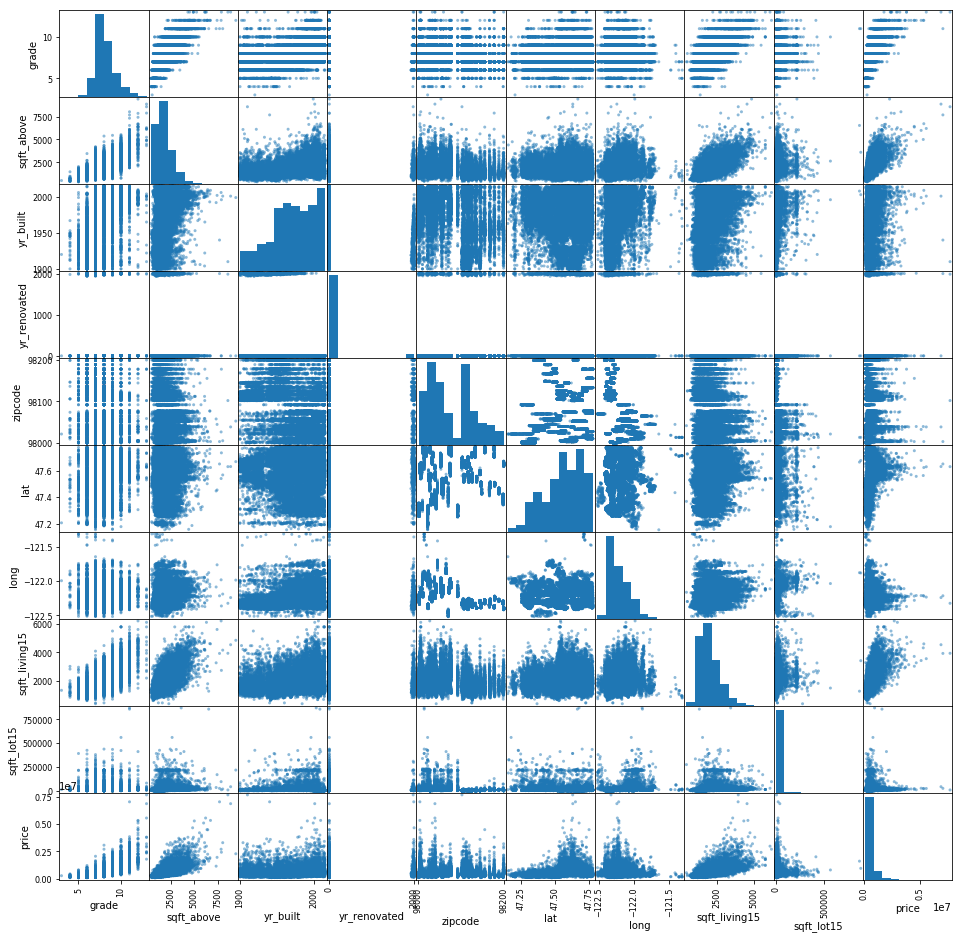

In [269]:
# Create scatter matrix
_ = pd.plotting.scatter_matrix(df_eda_2,figsize=(16,16))

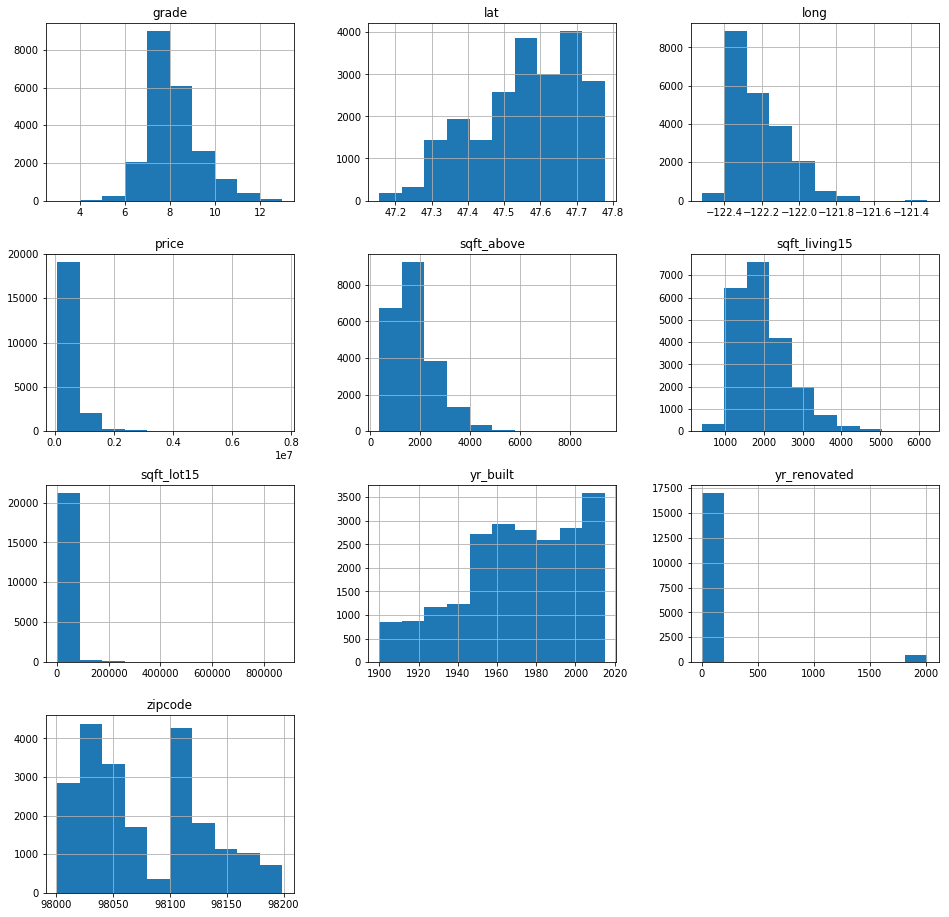

In [270]:
# Create histograms
_ = df_eda_2.hist(figsize=(16,16))

One last thing I might do is log transform price to see if that changes relationship with potential predictors.

In [ ]:
df_eda_2['log_price'] = df_eda_2['price'].apply( np.log )

In [ ]:
df_eda_2.head()

In [ ]:
# Create scatter matrix
_ = pd.plotting.scatter_matrix(df_eda_2.drop(['price'],axis=1),figsize=(16,16))

When took the log of `price` it seems to show more linear realtionships with many of my variables. So I think will recommend that we use `log_price` as our target variable.

### Initial observations and recommendations

- `grade` 
    - Appears to have linear relationship with, as well as being normally distributed 
    - No nulls
    - We confirmed that the King County scale is from 1-13.
    - <font color ="green">KEEP</font>
- `sqft_above`
    - No nulls
    - Appears to have linear relationship. Not normally distributed, but not sure if that's needed. 
    - <font color ="green">KEEP</font>
- `yr_built`
    - No nulls
    - After transformation of price it appears to have a linear relationship.
    - <font color ="green">KEEP</font>
- `sqft_basement`
    - Didn't get into the plots! Because it was an object. This was driven by `?` characters that were present in the column. Our initial idea is to transform it by assuming it is the difference between `sqft_totliving` and `sqft_above`. 
    - So we transformed the entire column by assuming as such:
            ` sqft_basement = sqft_totliving - sqft_above`
    - <font color ="red">NEED TO TRANSFORM</font>
- `yr_renovated`
    - There are a large number of nulls. We believe that it means that the house has not been renovated yet. There are also a large number with `0` entered, which we believe means the same thing. So for consistency of data we will transform the nulls all into `0`s.
    - <font color ="red">NEED TO TRANSFORM, replace `NaN` with 0</font>
- `zip code`
    - No nulls
    - But they are all `ints`. May need to scrub for zip+4. Also, think zip code should be considered to be more of a categorical variable. So think need to do two things:
    - 1. convert to `str`
    - 2. Truncate to 5 characters - (We confirmed it is!)
    - <font color ="red">NEED TO TRANSFORM</font>
- `lat` and `long`
    - No nulls
    - This appears to be very clean, with the caveat that some coordinates *may* fall out of King County.
    - <font color ="green">KEEP, but might want to see on a map</font>
- `sqft_living15`, `sqft_lot15`
    - No nulls
    - Distribution based on inspection of histogram seems reasonable.
    - <font color ="green">KEEP, for now</font>
    
    

        
    

---

# Data Cleaning

### Import the data

In [ ]:
df = pd.read_csv('kc_house_data.csv')

Based on our earlier exploratory data analysis we will perform the following data cleaning tasks.

#### 1. `waterfront`

There are some `NaN`s, we will encode them to `0` to be consistent with the rest of the data. We believe that `0` indicates the home is not on waterfront.

Before:

In [ ]:
df['waterfront'].unique()

Cleaning:

In [ ]:
df['waterfront'].replace(np.nan, 0, inplace=True)

After:

In [ ]:
df['waterfront'].unique()

#### 2. `view`

There are some `NaN`s, we will encode them to `0` to be consistent with the rest of the data. We don't know the actually scale of the 'scores', but think it's most likely they should be `0`.

Before:

In [ ]:
df['view'].unique()

Cleaning:

In [ ]:
df['view'].replace(np.nan, 0, inplace=True)

After:

In [ ]:
df['view'].unique()

#### 3. `sqft_basement`

There are rows where the value equals `?`, which caused the column to be coerced to `object`. We will assume (and spot checked to be true) that:  
`sqft_basement = sqft_totliving - sqft_above`  

We will replace all values of that column with this calculation so that they are all consistent.

Before:

In [ ]:
df['sqft_basement'].unique()

Cleaning:

In [ ]:
df['sqft_basement'] = df['sqft_living'] - df['sqft_above']

After:

In [ ]:
df['sqft_basement'].value_counts()

In [ ]:
df['sqft_basement'].dtype

In [ ]:
fig, ax = plt.subplots()

ax.hist(df['sqft_basement'])
ax.set_title('Distribution of sqft_basement')
ax.set_ylabel('Count')
ax.set_xlabel('sqft of basement')
plt.show()

#### 4. `yr_renovated`

There are a large number of nulls. We believe that it means that the house has not been renovated yet. There are also a large number with 0 entered, which we believe means the same thing. So for consistency of data we will transform the nulls all into 0s.


Before:

In [ ]:
df.loc[df['yr_renovated'].isna() == True,['yr_renovated']].shape[0]

There are 3.8k nulls.

Cleaning:

In [ ]:
df['yr_renovated'].replace(np.nan, 0.0, inplace=True)

After:

In [ ]:
df.loc[df['yr_renovated'].isna() == True,['yr_renovated']].shape[0]

No nulls!

#### 5. `zipcode`

The data was coerced into `int`. In practice zipcodes are more categorical in nature. So in anticpation of applying them as such we will convert them to `str`.


Before:

In [ ]:
df['zipcode'].dtype

Cleaning:

In [ ]:
df['zipcode'] = df['zipcode'].apply(str)

After:

In [573]:
df['zipcode'].dtype

dtype('O')

Let's take at our dataset up to this point:

In [574]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21597 entries, 0 to 21596
Data columns (total 22 columns):
id                21597 non-null int64
date              21597 non-null object
price             21597 non-null float64
bedrooms          21597 non-null int64
bathrooms         21597 non-null float64
sqft_living       21597 non-null int64
sqft_lot          21597 non-null int64
floors            21597 non-null float64
waterfront        21597 non-null float64
view              21597 non-null float64
condition         21597 non-null int64
grade             21597 non-null int64
sqft_above        21597 non-null int64
sqft_basement     21597 non-null int64
yr_built          21597 non-null int64
yr_renovated      21597 non-null float64
zipcode           21597 non-null object
lat               21597 non-null float64
long              21597 non-null float64
sqft_living15     21597 non-null int64
sqft_lot15        21597 non-null int64
date_formatted    21597 non-null datetime64[ns]
dtypes

Confirming that we have no nulls.

##### 6. `date` 

Now let us add a datetime column; it may come in handy later.

Converting:

In [575]:
df['date_formatted'] = pd.to_datetime(df['date'])

Checking:

In [576]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21597 entries, 0 to 21596
Data columns (total 22 columns):
id                21597 non-null int64
date              21597 non-null object
price             21597 non-null float64
bedrooms          21597 non-null int64
bathrooms         21597 non-null float64
sqft_living       21597 non-null int64
sqft_lot          21597 non-null int64
floors            21597 non-null float64
waterfront        21597 non-null float64
view              21597 non-null float64
condition         21597 non-null int64
grade             21597 non-null int64
sqft_above        21597 non-null int64
sqft_basement     21597 non-null int64
yr_built          21597 non-null int64
yr_renovated      21597 non-null float64
zipcode           21597 non-null object
lat               21597 non-null float64
long              21597 non-null float64
sqft_living15     21597 non-null int64
sqft_lot15        21597 non-null int64
date_formatted    21597 non-null datetime64[ns]
dtypes

Let's look at a few rows:

In [577]:
df.loc[:,['date','date_formatted']].head()

,date,date_formatted
0,10/13/2014,2014-10-13
1,12/9/2014,2014-12-09
2,2/25/2015,2015-02-25
3,12/9/2014,2014-12-09
4,2/18/2015,2015-02-18


In [578]:
df.loc[:,['date','date_formatted']].tail(10)

,date,date_formatted
21587,8/25/2014,2014-08-25
21588,1/26/2015,2015-01-26
21589,10/14/2014,2014-10-14
21590,3/26/2015,2015-03-26
21591,2/19/2015,2015-02-19
21592,5/21/2014,2014-05-21
21593,2/23/2015,2015-02-23
21594,6/23/2014,2014-06-23
21595,1/16/2015,2015-01-16
21596,10/15/2014,2014-10-15


Looks good.

#### Should we consider binarizing `zipcode`?

Since we consider `zipcode` to be categorical, we should binarize it.

In [579]:
zipcode_binarized = pd.get_dummies(df['zipcode'])

In [580]:
zipcode_binarized.head()


,98001,98002,98003,98004,98005,98006,98007,98008,98010,98011,...,98146,98148,98155,98166,98168,98177,98178,98188,98198,98199
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [581]:
zipcode_binarized.shape

(21597, 70)

This is as we expected.

----

We have performed all our preliminary cleansing. Now we will combine and clean into one dataset for exploring multicollinearity.

Append binarized zip codes:

In [582]:
df_m = pd.concat([df, zipcode_binarized], axis=1)

In [583]:
df_m.head()

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,98146,98148,98155,98166,98168,98177,98178,98188,98198,98199
0,7129300520,10/13/2014,221900.0,3,1.00,1180,5650,1.0,0.0,0.0,...,0,0,0,0,0,0,1,0,0,0
1,6414100192,12/9/2014,538000.0,3,2.25,2570,7242,2.0,0.0,0.0,...,0,0,0,0,0,0,0,0,0,0
2,5631500400,2/25/2015,180000.0,2,1.00,770,10000,1.0,0.0,0.0,...,0,0,0,0,0,0,0,0,0,0
3,2487200875,12/9/2014,604000.0,4,3.00,1960,5000,1.0,0.0,0.0,...,0,0,0,0,0,0,0,0,0,0
4,1954400510,2/18/2015,510000.0,3,2.00,1680,8080,1.0,0.0,0.0,...,0,0,0,0,0,0,0,0,0,0


Spot check that `zipcode` and its related binarized columns agree. 

For example, `98146':

In [584]:
df_m.loc[df_m['zipcode']=='98146',['zipcode','98146']].head()

,zipcode,98146
8,98146,1
160,98146,1
217,98146,1
225,98146,1
324,98146,1


Looks good! Let's check one more, `98105`:

In [585]:
df_m.loc[df_m['zipcode']=='98105',['zipcode','98105']].head()

,zipcode,98105
54,98105,1
55,98105,1
211,98105,1
308,98105,1
330,98105,1


Also, before we used the binarized `zipcodes` we should drop one. We will 'arbitrarily' select one.

In [586]:
df_m.drop(['98107'], axis=1, inplace=True)

Additionally, we can now drop `zipcode`.

In [587]:
df_m.drop(['zipcode'], axis=1, inplace=True)

In [588]:
#Check
df_m.columns

Index(['id', 'date', 'price', 'bedrooms', 'bathrooms', 'sqft_living',
       'sqft_lot', 'floors', 'waterfront', 'view', 'condition', 'grade',
       'sqft_above', 'sqft_basement', 'yr_built', 'yr_renovated', 'lat',
       'long', 'sqft_living15', 'sqft_lot15', 'date_formatted', '98001',
       '98002', '98003', '98004', '98005', '98006', '98007', '98008', '98010',
       '98011', '98014', '98019', '98022', '98023', '98024', '98027', '98028',
       '98029', '98030', '98031', '98032', '98033', '98034', '98038', '98039',
       '98040', '98042', '98045', '98052', '98053', '98055', '98056', '98058',
       '98059', '98065', '98070', '98072', '98074', '98075', '98077', '98092',
       '98102', '98103', '98105', '98106', '98108', '98109', '98112', '98115',
       '98116', '98117', '98118', '98119', '98122', '98125', '98126', '98133',
       '98136', '98144', '98146', '98148', '98155', '98166', '98168', '98177',
       '98178', '98188', '98198', '98199'],
      dtype='object')

Let's drop `date` since we have a nicely-formatted version of it now!

In [589]:
df_m.drop(['date'], axis=1, inplace=True)

In [590]:
#Check
df_m.columns

Index(['id', 'price', 'bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot',
       'floors', 'waterfront', 'view', 'condition', 'grade', 'sqft_above',
       'sqft_basement', 'yr_built', 'yr_renovated', 'lat', 'long',
       'sqft_living15', 'sqft_lot15', 'date_formatted', '98001', '98002',
       '98003', '98004', '98005', '98006', '98007', '98008', '98010', '98011',
       '98014', '98019', '98022', '98023', '98024', '98027', '98028', '98029',
       '98030', '98031', '98032', '98033', '98034', '98038', '98039', '98040',
       '98042', '98045', '98052', '98053', '98055', '98056', '98058', '98059',
       '98065', '98070', '98072', '98074', '98075', '98077', '98092', '98102',
       '98103', '98105', '98106', '98108', '98109', '98112', '98115', '98116',
       '98117', '98118', '98119', '98122', '98125', '98126', '98133', '98136',
       '98144', '98146', '98148', '98155', '98166', '98168', '98177', '98178',
       '98188', '98198', '98199'],
      dtype='object')

We've completed all our identified cleaning opportunities for now. However, we may identify other issues as we continue with our analysis. For our we will move on to analyzing our potential predictors for multicollinearity. 

----

# Multicollinearity Analysis

In [591]:
selected = [col for col in df_m.columns]
selected = selected[2:]
selected

['bedrooms',
 'bathrooms',
 'sqft_living',
 'sqft_lot',
 'floors',
 'waterfront',
 'view',
 'condition',
 'grade',
 'sqft_above',
 'sqft_basement',
 'yr_built',
 'yr_renovated',
 'lat',
 'long',
 'sqft_living15',
 'sqft_lot15',
 'date_formatted',
 '98001',
 '98002',
 '98003',
 '98004',
 '98005',
 '98006',
 '98007',
 '98008',
 '98010',
 '98011',
 '98014',
 '98019',
 '98022',
 '98023',
 '98024',
 '98027',
 '98028',
 '98029',
 '98030',
 '98031',
 '98032',
 '98033',
 '98034',
 '98038',
 '98039',
 '98040',
 '98042',
 '98045',
 '98052',
 '98053',
 '98055',
 '98056',
 '98058',
 '98059',
 '98065',
 '98070',
 '98072',
 '98074',
 '98075',
 '98077',
 '98092',
 '98102',
 '98103',
 '98105',
 '98106',
 '98108',
 '98109',
 '98112',
 '98115',
 '98116',
 '98117',
 '98118',
 '98119',
 '98122',
 '98125',
 '98126',
 '98133',
 '98136',
 '98144',
 '98146',
 '98148',
 '98155',
 '98166',
 '98168',
 '98177',
 '98178',
 '98188',
 '98198',
 '98199']

In [592]:
df_m = df_m.loc[:,selected]

In [593]:
selected = selected[2:]

In [594]:
df_m.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21597 entries, 0 to 21596
Data columns (total 87 columns):
bedrooms          21597 non-null int64
bathrooms         21597 non-null float64
sqft_living       21597 non-null int64
sqft_lot          21597 non-null int64
floors            21597 non-null float64
waterfront        21597 non-null float64
view              21597 non-null float64
condition         21597 non-null int64
grade             21597 non-null int64
sqft_above        21597 non-null int64
sqft_basement     21597 non-null int64
yr_built          21597 non-null int64
yr_renovated      21597 non-null float64
lat               21597 non-null float64
long              21597 non-null float64
sqft_living15     21597 non-null int64
sqft_lot15        21597 non-null int64
date_formatted    21597 non-null datetime64[ns]
98001             21597 non-null uint8
98002             21597 non-null uint8
98003             21597 non-null uint8
98004             21597 non-null uint8
98005     

In [595]:
df_m.corr()

,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,...,98146,98148,98155,98166,98168,98177,98178,98188,98198,98199
bedrooms,1.000000,0.514508,0.578212,0.032471,0.177944,-0.002127,0.078354,0.026496,0.356563,0.479386,...,-0.031151,-0.012931,-0.007890,0.000560,-0.045699,0.002700,-0.008118,0.005210,-0.023639,-0.021325
bathrooms,0.514508,1.000000,0.755758,0.088373,0.502582,0.063629,0.186016,-0.126479,0.665838,0.686668,...,-0.072893,-0.021539,-0.056804,-0.028999,-0.099712,-0.002250,-0.055332,-0.026073,-0.048801,0.008278
sqft_living,0.578212,0.755758,1.000000,0.173453,0.353953,0.104637,0.281715,-0.059445,0.762779,0.876448,...,-0.058106,-0.026323,-0.046455,-0.001475,-0.074826,0.028933,-0.042364,-0.024066,-0.041815,0.010832
sqft_lot,0.032471,0.088373,0.173453,1.000000,-0.004814,0.021459,0.075054,-0.008830,0.114731,0.184139,...,-0.017066,-0.007625,-0.016883,-0.003925,-0.010386,-0.008433,-0.018171,-0.009560,-0.012657,-0.028480
floors,0.177944,0.502582,0.353953,-0.004814,1.000000,0.020797,0.028414,-0.264075,0.458794,0.523989,...,-0.058567,-0.027030,-0.074127,-0.049343,-0.069556,-0.044079,-0.063447,-0.039260,-0.057147,-0.005799
waterfront,-0.002127,0.063629,0.104637,0.021459,0.020797,1.000000,0.380543,0.016648,0.082818,0.071778,...,0.019966,-0.004244,0.007887,0.064380,-0.009265,-0.003787,0.037313,-0.006567,0.035501,-0.005371
view,0.078354,0.186016,0.281715,0.075054,0.028414,0.380543,1.000000,0.045622,0.249082,0.166017,...,0.025785,-0.015687,-0.011922,0.061657,-0.032063,0.082709,0.043647,-0.008966,0.053909,0.050897
condition,0.026496,-0.126479,-0.059445,-0.008830,-0.264075,0.016648,0.045622,1.000000,-0.146896,-0.158904,...,-0.021116,-0.026858,0.014123,0.027666,-0.028394,0.014164,-0.015198,-0.009660,0.005819,0.018398
grade,0.356563,0.665838,0.762779,0.114731,0.458794,0.082818,0.249082,-0.146896,1.000000,0.756073,...,-0.082744,-0.031156,-0.060343,-0.024569,-0.109955,0.029681,-0.079451,-0.042148,-0.054154,0.036902
sqft_above,0.479386,0.686668,0.876448,0.184139,0.523989,0.071778,0.166017,-0.158904,0.756073,1.000000,...,-0.058110,-0.018775,-0.054476,-0.010955,-0.075234,0.006354,-0.061933,-0.028510,-0.043247,-0.029000


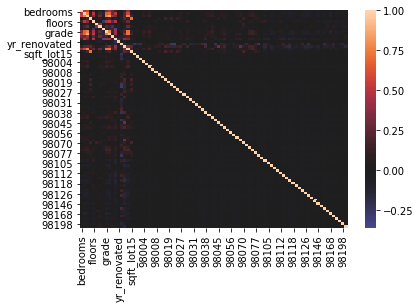

In [596]:
sns.heatmap(df_m.corr(), center=0);

Wow, that's alot of variables. Let's simplify by just looking without the binarized `zipcode`s for now.

In [597]:
df_m_small = df_m.iloc[:,0:18]

In [598]:
df_m_small.columns

Index(['bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot', 'floors',
       'waterfront', 'view', 'condition', 'grade', 'sqft_above',
       'sqft_basement', 'yr_built', 'yr_renovated', 'lat', 'long',
       'sqft_living15', 'sqft_lot15', 'date_formatted'],
      dtype='object')

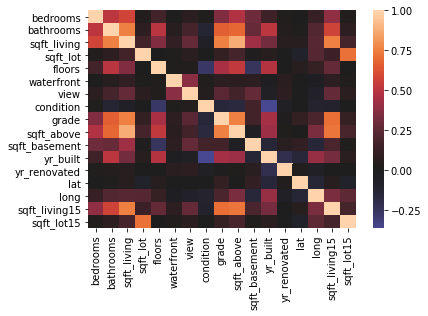

In [599]:
#Observe smaller dataset
sns.heatmap(df_m_small.corr(), center=0);

Let's also use the rule of thumb of correlations > .75 (absolute value)

Based on inspection of these results, if any of the variables are to be removed, we would remove `sqft_living` since it is highly correlated with a number of other variables, such as `bathrooms`, `grade`, `sqft_above` and `sqft_living15`.

In [600]:
# Create candidate dataframe
df_predictors = df_m.drop(['sqft_living'], axis=1)
df_predictors.columns

Index(['bedrooms', 'bathrooms', 'sqft_lot', 'floors', 'waterfront', 'view',
       'condition', 'grade', 'sqft_above', 'sqft_basement', 'yr_built',
       'yr_renovated', 'lat', 'long', 'sqft_living15', 'sqft_lot15',
       'date_formatted', '98001', '98002', '98003', '98004', '98005', '98006',
       '98007', '98008', '98010', '98011', '98014', '98019', '98022', '98023',
       '98024', '98027', '98028', '98029', '98030', '98031', '98032', '98033',
       '98034', '98038', '98039', '98040', '98042', '98045', '98052', '98053',
       '98055', '98056', '98058', '98059', '98065', '98070', '98072', '98074',
       '98075', '98077', '98092', '98102', '98103', '98105', '98106', '98108',
       '98109', '98112', '98115', '98116', '98117', '98118', '98119', '98122',
       '98125', '98126', '98133', '98136', '98144', '98146', '98148', '98155',
       '98166', '98168', '98177', '98178', '98188', '98198', '98199'],
      dtype='object')

----

# Feature Scaling and Normalization

Next, we will go through the variables and determine if they need further scaling or normalization.

In [601]:
# Here's Werlindo's columns
w_cols = [col for col in df_predictors.columns][0:8]
w_cols

['bedrooms',
 'bathrooms',
 'sqft_lot',
 'floors',
 'waterfront',
 'view',
 'condition',
 'grade']

#### 1. `bedrooms`

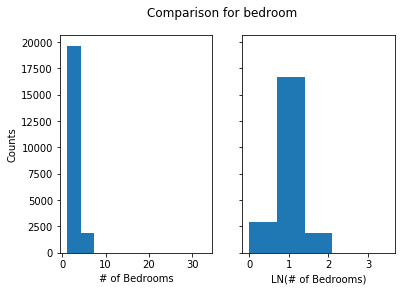

In [602]:
fig, ax = plt.subplots(1,2,sharey=True)

# First plot - no transformation
ax[0].hist(df_predictors['bedrooms'])
ax[0].set_ylabel("Counts")
ax[0].set_xlabel("# of Bedrooms")

# Second plot - log transformation
ax[1].hist(df_predictors['bedrooms'].apply(np.log), bins = 5)
ax[1].set_xlabel("LN(# of Bedrooms)")

plt.suptitle("Comparison for bedroom")
plt.show()

In [603]:
df_predictors['bedrooms'].value_counts()

3     9824
4     6882
2     2760
5     1601
6      272
1      196
7       38
8       13
9        6
10       3
11       1
33       1
Name: bedrooms, dtype: int64

Yes, let's take the log.

#### 2 . `bathrooms`

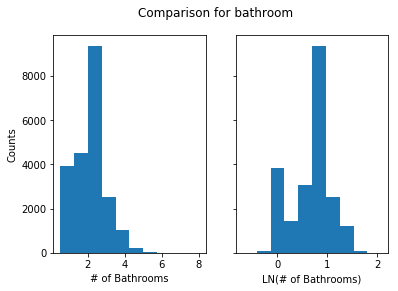

In [604]:
fig, ax = plt.subplots(1,2,sharey=True)

# First plot - no transformation
ax[0].hist(df_predictors['bathrooms'])
ax[0].set_ylabel("Counts")
ax[0].set_xlabel("# of Bathrooms")

# Second plot - log transformation
ax[1].hist(df_predictors['bathrooms'].apply(np.log))
ax[1].set_xlabel("LN(# of Bathrooms)")

plt.suptitle("Comparison for bathroom")
plt.show()

In [605]:
df_predictors['bathrooms'].value_counts()

2.50    5377
1.00    3851
1.75    3048
2.25    2047
2.00    1930
1.50    1445
2.75    1185
3.00     753
3.50     731
3.25     589
3.75     155
4.00     136
4.50     100
4.25      79
0.75      71
4.75      23
5.00      21
5.25      13
5.50      10
1.25       9
6.00       6
5.75       4
0.50       4
8.00       2
6.25       2
6.75       2
6.50       2
7.50       1
7.75       1
Name: bathrooms, dtype: int64

Yes, let's take the log.

#### 3. `sqft_lot`

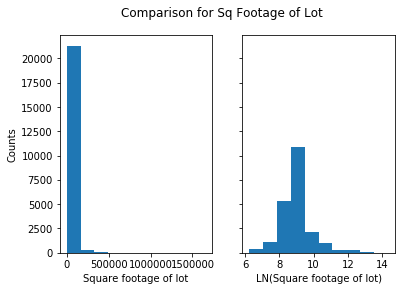

In [606]:
fig, ax = plt.subplots(1,2,sharey=True)

# First plot - no transformation
ax[0].hist(df_predictors['sqft_lot'])
ax[0].set_ylabel("Counts")
ax[0].set_xlabel("Square footage of lot")

# Second plot - log transformation
ax[1].hist(df_predictors['sqft_lot'].apply(np.log))
ax[1].set_xlabel("LN(Square footage of lot)")

plt.suptitle("Comparison for Sq Footage of Lot")
plt.show()

Yes, let's take the log.

#### 4. `floors`

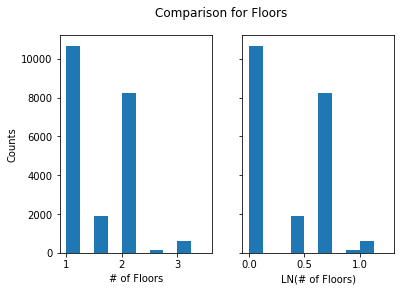

In [607]:
fig, ax = plt.subplots(1,2,sharey=True)

# First plot - no transformation
ax[0].hist(df_predictors['floors'])
ax[0].set_ylabel("Counts")
ax[0].set_xlabel("# of Floors")

# Second plot - log transformation
ax[1].hist(df_predictors['floors'].apply(np.log))
ax[1].set_xlabel("LN(# of Floors)")

plt.suptitle("Comparison for Floors")
plt.show()

In [608]:
df_predictors['floors'].value_counts()

1.0    10673
2.0     8235
1.5     1910
3.0      611
2.5      161
3.5        7
Name: floors, dtype: int64

Anecdotally, it's rare for a house to have more than 2 to 3 floors. So log transforming didn't do much. Might consider maybe making it `categorical`?

#### 5. `waterfront`

We forgot that `waterfront` is essentially a binary/categorical variable. So we will need to binarize it.

#### 6. `view`

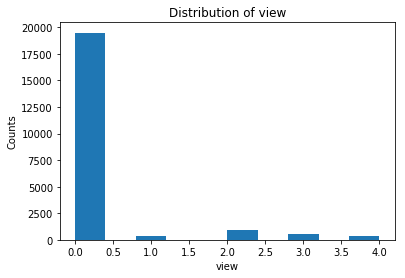

In [609]:
fig, ax = plt.subplots(1,1,sharey=True)

# First plot - no transformation
ax.hist(df_predictors['view'])
ax.set_ylabel("Counts")
ax.set_xlabel("view")
ax.set_title("Distribution of view")
plt.show()

This variable only has a few values. It might be better served to be treated as `categorical`.

#### 7. `condition`

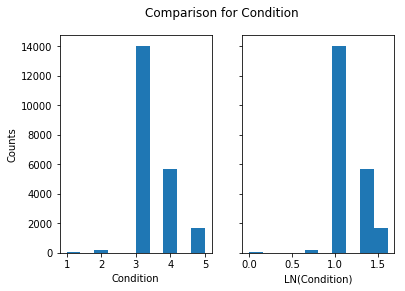

In [610]:
fig, ax = plt.subplots(1,2,sharey=True)

# First plot - no transformation
ax[0].hist(df_predictors['condition'])
ax[0].set_ylabel("Counts")
ax[0].set_xlabel("Condition")

# Second plot - log transformation
ax[1].hist(df_predictors['condition'].apply(np.log))
ax[1].set_xlabel("LN(Condition)")

plt.suptitle("Comparison for Condition")
plt.show()

The dimensionality of this variable is very low (only 5 values) and really only 3 values show up most of the time. Therefore we might be better served also binarizing/treating it as categorical? We might also consider just binning the first 3 groups since so few observations for `1` and `2`.

#### 8. `grade`

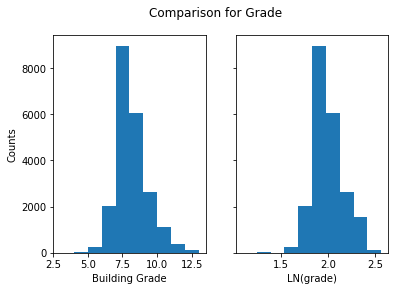

In [611]:
fig, ax = plt.subplots(1,2,sharey=True)

# First plot - no transformation
ax[0].hist(df_predictors['grade'])
ax[0].set_ylabel("Counts")
ax[0].set_xlabel("Building Grade")

# Second plot - log transformation
ax[1].hist(df_predictors['grade'].apply(np.log))
ax[1].set_xlabel("LN(grade)")

plt.suptitle("Comparison for Grade")
plt.show()

It already (at least to the eye test) seems pretty normal. So recommend leaving as is for now.

Next half is Hussein's half:

1. sqft_above

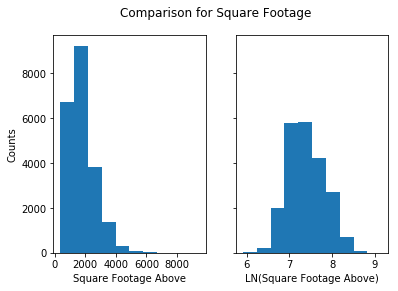

In [612]:
fig, ax = plt.subplots(1,2,sharey=True)

# First plot - no transformation
ax[0].hist(df_predictors['sqft_above'])
ax[0].set_ylabel("Counts")
ax[0].set_xlabel("Square Footage Above")

# Second plot - log transformation
ax[1].hist(df_predictors['sqft_above'].apply(np.log))
ax[1].set_xlabel("LN(Square Footage Above)")

plt.suptitle("Comparison for Square Footage")
plt.show()

2. sqft_basement

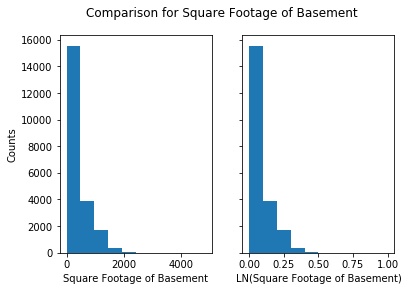

In [613]:
fig, ax = plt.subplots(1,2,sharey=True)

# First plot - no transformation
ax[0].hist(df_predictors['sqft_basement'])
ax[0].set_ylabel("Counts")
ax[0].set_xlabel("Square Footage of Basement")

# Second plot - log transformation
ax[1].hist((df_predictors['sqft_basement']-min(df_predictors['sqft_basement']))/(max(df_predictors['sqft_basement'])-min(df_predictors['sqft_basement'])))
ax[1].set_xlabel("LN(Square Footage of Basement)")

plt.suptitle("Comparison for Square Footage of Basement")
plt.show()

3. yr_built

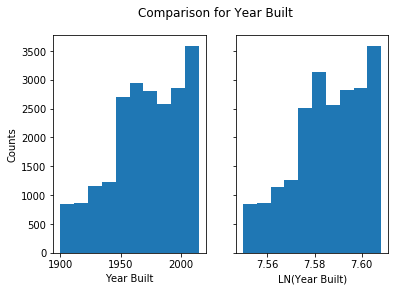

In [614]:
fig, ax = plt.subplots(1,2,sharey=True)

# First plot - no transformation
ax[0].hist(df_predictors['yr_built'])
ax[0].set_ylabel("Counts")
ax[0].set_xlabel("Year Built")

# Second plot - log transformation
ax[1].hist(df_predictors['yr_built'].apply(np.log))
ax[1].set_xlabel("LN(Year Built)")

plt.suptitle("Comparison for Year Built")
plt.show()

4. yr_renovated

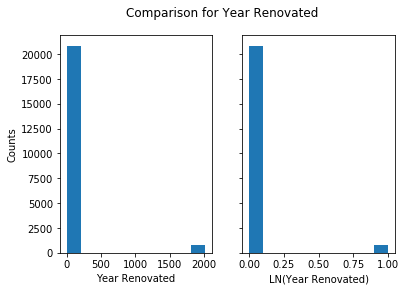

In [615]:
fig, ax = plt.subplots(1,2,sharey=True)

# First plot - no transformation
ax[0].hist(df_predictors['yr_renovated'])
ax[0].set_ylabel("Counts")
ax[0].set_xlabel("Year Renovated")

# Second plot - log transformation
ax[1].hist((df_predictors['yr_renovated']-min(df_predictors['yr_renovated']))/(max(df_predictors['yr_renovated'])-min(df_predictors['yr_renovated'])))
ax[1].set_xlabel("LN(Year Renovated)")

plt.suptitle("Comparison for Year Renovated")
plt.show()

5. latitude

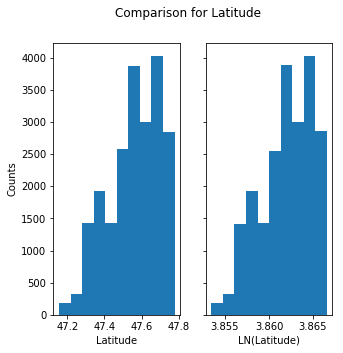

In [616]:
fig, ax = plt.subplots(1,2,sharey=True, figsize=(5,5))

# First plot - no transformation
ax[0].hist(df_predictors['lat'])
ax[0].set_ylabel("Counts")
ax[0].set_xlabel("Latitude")

# Second plot - log transformation
ax[1].hist(df_predictors['lat'].apply(np.log))
ax[1].set_xlabel("LN(Latitude)")

plt.suptitle("Comparison for Latitude")
plt.show()

6. Longitude

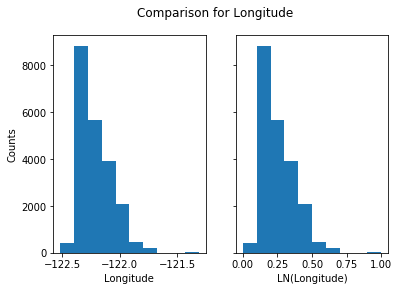

In [617]:
fig, ax = plt.subplots(1,2,sharey=True)

# First plot - no transformation
ax[0].hist(df_predictors['long'])
ax[0].set_ylabel("Counts")
ax[0].set_xlabel("Longitude")

# Second plot - log transformation
ax[1].hist((df_predictors['long']-min(df_predictors['long']))/(max(df_predictors['long'])-min(df_predictors['long'])))
ax[1].set_xlabel("LN(Longitude)")

plt.suptitle("Comparison for Longitude")
plt.show()

7. sqft_living15

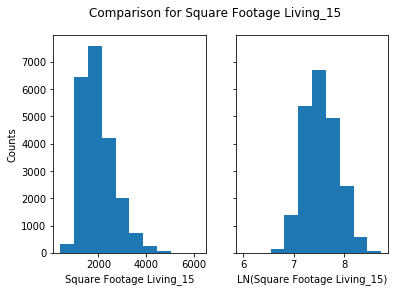

In [618]:
fig, ax = plt.subplots(1,2,sharey=True)

# First plot - no transformation
ax[0].hist(df_predictors['sqft_living15'])
ax[0].set_ylabel("Counts")
ax[0].set_xlabel("Square Footage Living_15")

# Second plot - log transformation
ax[1].hist(df_predictors['sqft_living15'].apply(np.log))
ax[1].set_xlabel("LN(Square Footage Living_15)")

plt.suptitle("Comparison for Square Footage Living_15")
plt.show()

8. sqft_lot15

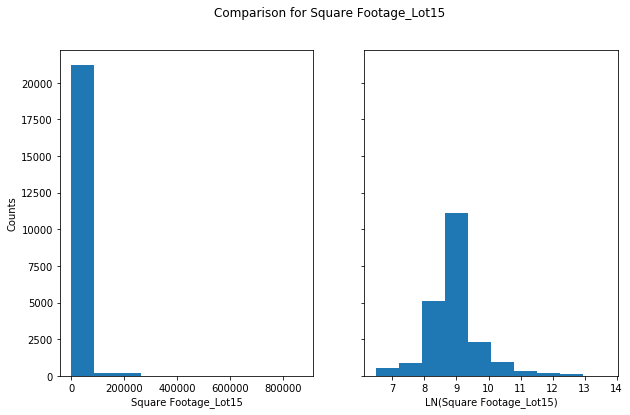

In [619]:
fig, ax = plt.subplots(1,2,sharey=True,figsize=(10,6))

# First plot - no transformation
ax[0].hist(df_predictors['sqft_lot15'])
ax[0].set_ylabel("Counts")
ax[0].set_xlabel("Square Footage_Lot15")

# Second plot - log transformation
ax[1].hist(df_predictors['sqft_lot15'].apply(np.log))
ax[1].set_xlabel("LN(Square Footage_Lot15)")

plt.suptitle("Comparison for Square Footage_Lot15")
plt.show()

---

# More data cleaning

After we analyzed our existing variables for potential to transformation/normalize/standardize, we arrived at a set of variables to do so with, as well as a few more data cleaning tasks.

In [620]:
df3 = df_predictors.copy()
df3.columns

Index(['bedrooms', 'bathrooms', 'sqft_lot', 'floors', 'waterfront', 'view',
       'condition', 'grade', 'sqft_above', 'sqft_basement', 'yr_built',
       'yr_renovated', 'lat', 'long', 'sqft_living15', 'sqft_lot15',
       'date_formatted', '98001', '98002', '98003', '98004', '98005', '98006',
       '98007', '98008', '98010', '98011', '98014', '98019', '98022', '98023',
       '98024', '98027', '98028', '98029', '98030', '98031', '98032', '98033',
       '98034', '98038', '98039', '98040', '98042', '98045', '98052', '98053',
       '98055', '98056', '98058', '98059', '98065', '98070', '98072', '98074',
       '98075', '98077', '98092', '98102', '98103', '98105', '98106', '98108',
       '98109', '98112', '98115', '98116', '98117', '98118', '98119', '98122',
       '98125', '98126', '98133', '98136', '98144', '98146', '98148', '98155',
       '98166', '98168', '98177', '98178', '98188', '98198', '98199'],
      dtype='object')

#### `sqft_above`

In [621]:
df3['sqft_above_log'] = df3['sqft_above'].apply(np.log)
df3.loc[:,['sqft_above','sqft_above_log']].head()

,sqft_above,sqft_above_log
0,1180,7.073270
1,2170,7.682482
2,770,6.646391
3,1050,6.956545
4,1680,7.426549


#### `sqft_living15`

In [622]:
df3['sqft_living15_log'] = df3['sqft_living15'].apply(np.log)
df3.loc[:,['sqft_living15','sqft_living15_log']].head()

,sqft_living15,sqft_living15_log
0,1340,7.200425
1,1690,7.432484
2,2720,7.908387
3,1360,7.215240
4,1800,7.495542


#### `sqft_lot15`

In [623]:
df3['sqft_lot15_log'] = df3['sqft_lot15'].apply(np.log)
df3.loc[:,['sqft_lot15','sqft_lot15_log']].head()

,sqft_lot15,sqft_lot15_log
0,5650,8.639411
1,7639,8.941022
2,8062,8.994917
3,5000,8.517193
4,7503,8.923058


#### `bedrooms`

In [624]:
df3['bedrooms_log'] = df3['bedrooms'].apply(np.log)
df3.loc[:,['bedrooms','bedrooms_log']].head()

,bedrooms,bedrooms_log
0,3,1.098612
1,3,1.098612
2,2,0.693147
3,4,1.386294
4,3,1.098612


#### `bathrooms`

In [625]:
df3['bathrooms_log'] = df3['bathrooms'].apply(np.log)
df3.loc[:,['bathrooms','bathrooms_log']].head()

,bathrooms,bathrooms_log
0,1.00,0.000000
1,2.25,0.810930
2,1.00,0.000000
3,3.00,1.098612
4,2.00,0.693147


#### `sqft_lot`

In [626]:
df3['sqft_lot_log'] = df3['sqft_lot'].apply(np.log)
df3.loc[:,['sqft_lot','sqft_lot_log']].head()

,sqft_lot,sqft_lot_log
0,5650,8.639411
1,7242,8.887653
2,10000,9.210340
3,5000,8.517193
4,8080,8.997147


#### `floors`

In [627]:
floors_binarized = pd.get_dummies(df3['floors'],prefix="floors")

In [628]:
floors_binarized.head()


,floors_1.0,floors_1.5,floors_2.0,floors_2.5,floors_3.0,floors_3.5
0,1,0,0,0,0,0
1,0,0,1,0,0,0
2,1,0,0,0,0,0
3,1,0,0,0,0,0
4,1,0,0,0,0,0


In [629]:
floors_binarized.shape

(21597, 6)

In [630]:
df3 = pd.concat([df3, floors_binarized], axis=1)

In [631]:
df3.head()

,bedrooms,bathrooms,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,...,sqft_lot15_log,bedrooms_log,bathrooms_log,sqft_lot_log,floors_1.0,floors_1.5,floors_2.0,floors_2.5,floors_3.0,floors_3.5
0,3,1.00,5650,1.0,0.0,0.0,3,7,1180,0,...,8.639411,1.098612,0.000000,8.639411,1,0,0,0,0,0
1,3,2.25,7242,2.0,0.0,0.0,3,7,2170,400,...,8.941022,1.098612,0.810930,8.887653,0,0,1,0,0,0
2,2,1.00,10000,1.0,0.0,0.0,3,6,770,0,...,8.994917,0.693147,0.000000,9.210340,1,0,0,0,0,0
3,4,3.00,5000,1.0,0.0,0.0,5,7,1050,910,...,8.517193,1.386294,1.098612,8.517193,1,0,0,0,0,0
4,3,2.00,8080,1.0,0.0,0.0,3,8,1680,0,...,8.923058,1.098612,0.693147,8.997147,1,0,0,0,0,0


In [632]:
# Drop one of the binarized columns
df3.drop(['floors_3.5'], axis=1, inplace=True)

#### `waterfront`

In [633]:
waterfront_binarized = pd.get_dummies(df3['waterfront'],prefix="wf")

In [634]:
waterfront_binarized.head()


,wf_0.0,wf_1.0
0,1,0
1,1,0
2,1,0
3,1,0
4,1,0


In [635]:
waterfront_binarized.shape

(21597, 2)

In [636]:
df3 = pd.concat([df3, waterfront_binarized], axis=1)

In [637]:
df3.head()

,bedrooms,bathrooms,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,...,bedrooms_log,bathrooms_log,sqft_lot_log,floors_1.0,floors_1.5,floors_2.0,floors_2.5,floors_3.0,wf_0.0,wf_1.0
0,3,1.00,5650,1.0,0.0,0.0,3,7,1180,0,...,1.098612,0.000000,8.639411,1,0,0,0,0,1,0
1,3,2.25,7242,2.0,0.0,0.0,3,7,2170,400,...,1.098612,0.810930,8.887653,0,0,1,0,0,1,0
2,2,1.00,10000,1.0,0.0,0.0,3,6,770,0,...,0.693147,0.000000,9.210340,1,0,0,0,0,1,0
3,4,3.00,5000,1.0,0.0,0.0,5,7,1050,910,...,1.386294,1.098612,8.517193,1,0,0,0,0,1,0
4,3,2.00,8080,1.0,0.0,0.0,3,8,1680,0,...,1.098612,0.693147,8.997147,1,0,0,0,0,1,0


In [638]:
# Drop one of the binarized columns
df3.drop(['wf_1.0'], axis=1, inplace=True)

#### `view`

In [639]:
view_binarized = pd.get_dummies(df3['view'],prefix="view")

In [640]:
view_binarized.head()


,view_0.0,view_1.0,view_2.0,view_3.0,view_4.0
0,1,0,0,0,0
1,1,0,0,0,0
2,1,0,0,0,0
3,1,0,0,0,0
4,1,0,0,0,0


In [641]:
view_binarized.shape

(21597, 5)

In [642]:
df3 = pd.concat([df3, view_binarized], axis=1)

In [643]:
df3.head()

,bedrooms,bathrooms,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,...,floors_1.5,floors_2.0,floors_2.5,floors_3.0,wf_0.0,view_0.0,view_1.0,view_2.0,view_3.0,view_4.0
0,3,1.00,5650,1.0,0.0,0.0,3,7,1180,0,...,0,0,0,0,1,1,0,0,0,0
1,3,2.25,7242,2.0,0.0,0.0,3,7,2170,400,...,0,1,0,0,1,1,0,0,0,0
2,2,1.00,10000,1.0,0.0,0.0,3,6,770,0,...,0,0,0,0,1,1,0,0,0,0
3,4,3.00,5000,1.0,0.0,0.0,5,7,1050,910,...,0,0,0,0,1,1,0,0,0,0
4,3,2.00,8080,1.0,0.0,0.0,3,8,1680,0,...,0,0,0,0,1,1,0,0,0,0


In [644]:
# Drop one of the binarized columns
df3.drop(['view_4.0'], axis=1, inplace=True)

#### `condition`

In [645]:
condition_binarized = pd.get_dummies(df3['condition'],prefix="cond")

In [646]:
condition_binarized.head()


,cond_1,cond_2,cond_3,cond_4,cond_5
0,0,0,1,0,0
1,0,0,1,0,0
2,0,0,1,0,0
3,0,0,0,0,1
4,0,0,1,0,0


In [647]:
condition_binarized.shape

(21597, 5)

In [648]:
df3 = pd.concat([df3, condition_binarized], axis=1)

In [649]:
df3.head()

,bedrooms,bathrooms,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,...,wf_0.0,view_0.0,view_1.0,view_2.0,view_3.0,cond_1,cond_2,cond_3,cond_4,cond_5
0,3,1.00,5650,1.0,0.0,0.0,3,7,1180,0,...,1,1,0,0,0,0,0,1,0,0
1,3,2.25,7242,2.0,0.0,0.0,3,7,2170,400,...,1,1,0,0,0,0,0,1,0,0
2,2,1.00,10000,1.0,0.0,0.0,3,6,770,0,...,1,1,0,0,0,0,0,1,0,0
3,4,3.00,5000,1.0,0.0,0.0,5,7,1050,910,...,1,1,0,0,0,0,0,0,0,1
4,3,2.00,8080,1.0,0.0,0.0,3,8,1680,0,...,1,1,0,0,0,0,0,1,0,0


In [650]:
# Drop one of the binarized columns
df3.drop(['cond_5'], axis=1, inplace=True)

The following we concluded to not transform:  
- `sqft_basement`
- `yr_built`
- `yr_renovated`
- `lat`
- `long`
- `grade`

We have alot of variables!

In [651]:
# Show our variables to date
df3.columns

Index(['bedrooms', 'bathrooms', 'sqft_lot', 'floors', 'waterfront', 'view',
       'condition', 'grade', 'sqft_above', 'sqft_basement',
       ...
       'floors_3.0', 'wf_0.0', 'view_0.0', 'view_1.0', 'view_2.0', 'view_3.0',
       'cond_1', 'cond_2', 'cond_3', 'cond_4'],
      dtype='object', length=106)

Since we did a few more transformations, we will do another instance of multicollinearity analysis.

#### Multicollinearity - Take 2

In [652]:
df3.drop(['waterfront','view','condition','floors'], axis=1, inplace=True)

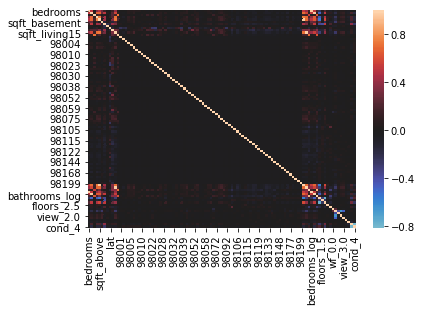

In [653]:
sns.heatmap(df3.corr(), center=0);

This heatmap is hard to interpret. It appears that zipcodes aren't outliers with respect to correlation, so we will reduce the columns to exclude them.

In [654]:
columns = [col for col in df3.columns]
columns

['bedrooms',
 'bathrooms',
 'sqft_lot',
 'grade',
 'sqft_above',
 'sqft_basement',
 'yr_built',
 'yr_renovated',
 'lat',
 'long',
 'sqft_living15',
 'sqft_lot15',
 'date_formatted',
 '98001',
 '98002',
 '98003',
 '98004',
 '98005',
 '98006',
 '98007',
 '98008',
 '98010',
 '98011',
 '98014',
 '98019',
 '98022',
 '98023',
 '98024',
 '98027',
 '98028',
 '98029',
 '98030',
 '98031',
 '98032',
 '98033',
 '98034',
 '98038',
 '98039',
 '98040',
 '98042',
 '98045',
 '98052',
 '98053',
 '98055',
 '98056',
 '98058',
 '98059',
 '98065',
 '98070',
 '98072',
 '98074',
 '98075',
 '98077',
 '98092',
 '98102',
 '98103',
 '98105',
 '98106',
 '98108',
 '98109',
 '98112',
 '98115',
 '98116',
 '98117',
 '98118',
 '98119',
 '98122',
 '98125',
 '98126',
 '98133',
 '98136',
 '98144',
 '98146',
 '98148',
 '98155',
 '98166',
 '98168',
 '98177',
 '98178',
 '98188',
 '98198',
 '98199',
 'sqft_above_log',
 'sqft_living15_log',
 'sqft_lot15_log',
 'bedrooms_log',
 'bathrooms_log',
 'sqft_lot_log',
 'floors_1.0',
 

In [655]:
columns_keep = []
for col in columns:
    if not(col.startswith('98')):
        columns_keep.append(col)
columns_keep

['bedrooms',
 'bathrooms',
 'sqft_lot',
 'grade',
 'sqft_above',
 'sqft_basement',
 'yr_built',
 'yr_renovated',
 'lat',
 'long',
 'sqft_living15',
 'sqft_lot15',
 'date_formatted',
 'sqft_above_log',
 'sqft_living15_log',
 'sqft_lot15_log',
 'bedrooms_log',
 'bathrooms_log',
 'sqft_lot_log',
 'floors_1.0',
 'floors_1.5',
 'floors_2.0',
 'floors_2.5',
 'floors_3.0',
 'wf_0.0',
 'view_0.0',
 'view_1.0',
 'view_2.0',
 'view_3.0',
 'cond_1',
 'cond_2',
 'cond_3',
 'cond_4']

We forgot to drop the variables we binarized, we will do that now:

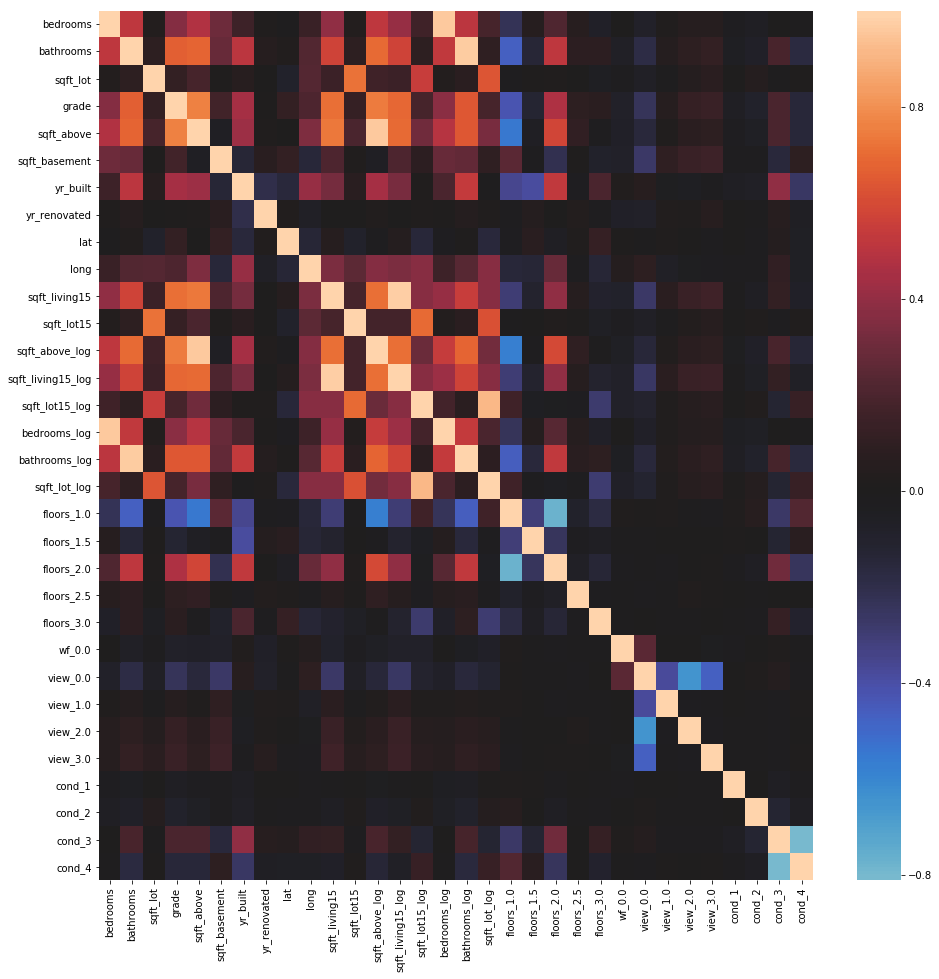

In [656]:
fig, ax = plt.subplots(figsize=(16,16))
sns.heatmap(df3.loc[:,columns_keep].corr(), center=0);

---

In [657]:
abs(df3.corr()) > 0.75

,bedrooms,bathrooms,sqft_lot,grade,sqft_above,sqft_basement,yr_built,yr_renovated,lat,long,...,floors_3.0,wf_0.0,view_0.0,view_1.0,view_2.0,view_3.0,cond_1,cond_2,cond_3,cond_4
bedrooms,True,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
bathrooms,False,True,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
sqft_lot,False,False,True,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
grade,False,False,False,True,True,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
sqft_above,False,False,False,True,True,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
sqft_basement,False,False,False,False,False,True,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
yr_built,False,False,False,False,False,False,True,False,False,False,...,False,False,False,False,False,False,False,False,False,False
yr_renovated,False,False,False,False,False,False,False,True,False,False,...,False,False,False,False,False,False,False,False,False,False
lat,False,False,False,False,False,False,False,False,True,False,...,False,False,False,False,False,False,False,False,False,False
long,False,False,False,False,False,False,False,False,False,True,...,False,False,False,False,False,False,False,False,False,False


### Target Variable: Should we log transform `Price`?

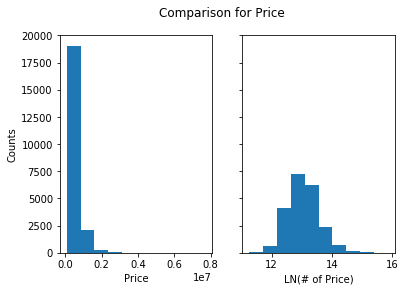

In [658]:
fig, ax = plt.subplots(1,2,sharey=True)

# First plot - no transformation
ax[0].hist(df['price'])
ax[0].set_ylabel("Counts")
ax[0].set_xlabel("Price")

# Second plot - log transformation
ax[1].hist(df['price'].apply(np.log))
ax[1].set_xlabel("LN(# of Price)")

plt.suptitle("Comparison for Price")
plt.show()

It defintely looks more normal, so we will consider log transforming `Price` as one of our iterations.

## Digression: 
We want to save my results, so for now I will use a list of dictionaries

In [882]:
#I want to save results of all my modeling 

# Create a dictionary to hold a single model's results
def store_results_to_dict(model_name, model_desc, num_pred, r2, r2_adj
                          ,cv_10_mse_mean=np.nan,cv_10_mse_std=np.nan
                         ,cv_10_rmse_mean=np.nan,cv_10_rmse_std=np.nan
                         ,cv_10_mape_mean=np.nan,cv_10_mape_std=np.nan):
    curr_dict = {'model_name':model_name
                 ,'model_desc':model_desc
                 ,'num_predictors':num_pred
                 ,'r2':r2
                 ,'r2_adj':r2_adj
                 ,'cv_10_mse_mean':cv_10_mse_mean
                 ,'cv_10_mse_std':cv_10_mse_std
                 ,'cv_10_rmse_mean':cv_10_rmse_mean
                 ,'cv_10_rmse_std':cv_10_rmse_std
                 ,'cv_10_mape_mean':cv_10_mape_mean
                 ,'cv_10_mape_std':cv_10_mape_std
                }
    return curr_dict

# Want to keep list of all result dictionaries
results = []

# Train/Test Split

Before running any modeling, we want to separate our data into `train` and `test` sets. We will train our models on `train` and do final validation on `test`.

In [660]:
# Set seed for reproducibility
np.random.seed(1111)

In [661]:
y = df['price']
X = df3
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2)

In [662]:
X_train.shape

(17277, 102)

# Model 1 - All Candidate Variables
### `Price` untransformed

We are going to start modeling to learn more above our variables! For this first run we are going to use ALL our variables.

In [663]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 17277 entries, 20895 to 16695
Columns: 102 entries, bedrooms to cond_4
dtypes: datetime64[ns](1), float64(10), int64(8), uint8(83)
memory usage: 4.0 MB


In [664]:
# Before we proceeed, let's remove `date_formatted`
X_train = X_train.drop(['date_formatted'], axis=1).copy()
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 17277 entries, 20895 to 16695
Columns: 101 entries, bedrooms to cond_4
dtypes: float64(10), int64(8), uint8(83)
memory usage: 3.9 MB


In [665]:
# Set up predictors
predictors = sm.add_constant(X_train)

# Model SM LR model
model_1 = sm.OLS(y_train, predictors).fit()

# View Results
model_1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.829
Model:                            OLS   Adj. R-squared:                  0.828
Method:                 Least Squares   F-statistic:                     824.4
Date:                Wed, 17 Apr 2019   Prob (F-statistic):               0.00
Time:                        23:13:02   Log-Likelihood:            -2.3067e+05
No. Observations:               17277   AIC:                         4.615e+05
Df Residuals:                   17175   BIC:                         4.623e+05
Df Model:                         101                                         
Covariance Type:            nonrobust                                         
=====================================================================================
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
const             -3.946e+07   6.67e+06     -5.917      0.000   -5.25e+07   -2.64e+07
bedrooms          -3.547e+04   4511.141     -7.862      0.000   -4.43e+04   -2.66e+04
bathrooms          1.683e+05   7768.347     21.661      0.000    1.53e+05    1.83e+05
sqft_lot             -0.0669      0.053     -1.255      0.210      -0.171       0.038
grade               6.02e+04   1971.087     30.540      0.000    5.63e+04    6.41e+04
sqft_above          263.9541      7.105     37.152      0.000     250.028     277.880
sqft_basement       114.6025      3.785     30.276      0.000     107.183     122.022
yr_built           -211.8703     76.303     -2.777      0.005    -361.432     -62.308
yr_renovated         22.5626      3.451      6.538      0.000      15.798      29.327
lat                2.277e+05   6.75e+04      3.376      0.001    9.55e+04     3.6e+05
long              -2.608e+05   4.94e+04     -5.277      0.000   -3.58e+05   -1.64e+05
sqft_living15        90.6798      9.776      9.276      0.000      71.518     109.842
sqft_lot15           -0.3493      0.084     -4.170      0.000      -0.513      -0.185
98001             -2.448e+05   2.84e+04     -8.616      0.000      -3e+05   -1.89e+05
98002             -2.153e+05   2.99e+04     -7.210      0.000   -2.74e+05   -1.57e+05
98003             -2.641e+05   2.83e+04     -9.345      0.000    -3.2e+05   -2.09e+05
98004              4.639e+05   1.71e+04     27.171      0.000     4.3e+05    4.97e+05
98005              2.071e+04   2.05e+04      1.011      0.312   -1.94e+04    6.09e+04
98006             -1.916e+04   1.88e+04     -1.019      0.308    -5.6e+04    1.77e+04
98007             -2.795e+04   2.16e+04     -1.295      0.195   -7.02e+04    1.43e+04
98008             -1.483e+04   1.99e+04     -0.746      0.456   -5.38e+04    2.41e+04
98010             -1.197e+05   3.49e+04     -3.431      0.001   -1.88e+05   -5.13e+04
98011             -1.948e+05   1.93e+04    -10.102      0.000   -2.33e+05   -1.57e+05
98014             -1.297e+05   3.13e+04     -4.144      0.000   -1.91e+05   -6.84e+04
98019             -1.683e+05   2.71e+04     -6.208      0.000   -2.21e+05   -1.15e+05
98022             -1.562e+05   3.82e+04     -4.089      0.000   -2.31e+05   -8.14e+04
98023             -3.077e+05   2.79e+04    -11.047      0.000   -3.62e+05   -2.53e+05
98024             -6.999e+04   3.23e+04     -2.164      0.030   -1.33e+05   -6591.554
98027              -7.61e+04    2.3e+04     -3.311      0.001   -1.21e+05    -3.1e+04
98028             -2.126e+05   1.73e+04    -12.279      0.000   -2.47e+05   -1.79e+05
98029             -1.233e+04   2.41e+04     -0.512      0.608   -5.95e+04    3.48e+04
98030             -2.227e+05   2.65e+04     -8.397      0.000   -2.75e+05   -1.71e+05
98031             -2.225e+05   2.47e+04     -9.017      0.000   -2.71e+05

From $R^2$ perspective this model appears to very good. There appears to be a number of insignificant variables, which is not surprising since we threw in **all** of our candidate variables.

## Cross Validation - Round 1

First, some setup for required libraries.

In [666]:
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression

In [667]:
linreg = LinearRegression()
X = X_train
y = y_train

In [668]:
cv_10_res_mean = np.mean(cross_val_score(linreg, X, y, cv=10, scoring="neg_mean_squared_error"))
cv_10_res_std = np.std(cross_val_score(linreg, X, y, cv=10, scoring="neg_mean_squared_error"))

In [671]:
print("Accuracy: {:,.2f} (+/- {:,.2f})".format(cv_10_res_mean, cv_10_res_std * 2))

Accuracy: -23,806,940,212.02 (+/- 8,452,428,281.80)


In [672]:
results.append(store_results_to_dict('model_1','All preliminary variables included'
                                     ,model_1.rsquared, model_1.rsquared_adj
                                    ,cv_10_res_mean, cv_10_res_std))               

### Alternative Cross-Validation

We created a custom k-folds cross validation function to automatically account for the log-transformation. 

Also, in addition to `MSE/RMSE` we are option to include **Mean Absolute Percentage Error** as another validation/evaluation metric. We think this metric will be easier to explain to our stakeholders as it represents the average percentage "off" of the prediction model. It is defined as:

$M = \frac{100\%}{n}\sum_{t=1}^{n}\lvert \frac {A_{t}-F_{t}}{A_{t}}\rvert$

In [813]:
# import importlib
# importlib.reload(dad)

In [814]:
import daddy as dad # Our custom function(s)

We are using 10 folds as balance between too few and too many, and to be transparent seems to be a common rule of thumb. With more time we may have explored other 'rules' (for example we found a *standard deviation rule* for selection `k`).

In [903]:
res_mod = dad.custom_k_fold(X_train, y_train, 10, verbose=False, log=False)

In [904]:
res_df = pd.DataFrame(res_mod)

Let's prove to ourselves that this works.  
Calculate average test MSE: 

In [905]:
res_df['mse_test'].mean()

23806940212.021126

In [906]:
np.mean(res_df['mse_test'])

23806940212.021126

In [907]:
np.std(res_df['mse_test'])

4226214140.899766

This matches the results from `cross_val_score`! Yes.

Ok, in this case let's replace our cross-validation methodology with our custom function!

In [908]:
X_train.shape[1]

101

In [909]:
model_1.df_model

101.0

In [910]:
# replace results
results = []

In [911]:
results.append(store_results_to_dict('model_1','All preliminary variables included'
                                     ,model_1.df_model
                                     ,model_1.rsquared, model_1.rsquared_adj
                                     ,np.mean(res_df['mse_test'])
                                     ,np.std(res_df['mse_test'])
                                     ,np.mean(res_df['rmse_test'])
                                     ,np.std(res_df['rmse_test'])
                                     ,np.mean(res_df['mape_test'])
                                     ,np.std(res_df['mape_test'])
                                ))               

In [912]:
results

[{'model_name': 'model_1',
  'model_desc': 'All preliminary variables included',
  'num_predictors': 101.0,
  'r2': 0.8290043904363273,
  'r2_adj': 0.8279988267352543,
  'cv_10_mse_mean': 23806940212.021126,
  'cv_10_mse_std': 4226214140.899766,
  'cv_10_rmse_mean': 153743.6824331373,
  'cv_10_rmse_std': 13031.51272568752,
  'cv_10_mape_mean': 18.045001967784597,
  'cv_10_mape_std': 0.32677193317554243}]

# Model 2 - Removed insignificant variables from M.1
### `Price` untransformed


For this version we will drop all the columns that had `p-value > .05`.

In [674]:
# So one brute-force way to pare down this model is throw out variables that have high p-values.
drop_candidates = model_1.pvalues[model_1.pvalues > .05].reset_index()['index'].tolist()
drop_candidates

['sqft_lot',
 '98005',
 '98006',
 '98007',
 '98008',
 '98029',
 '98045',
 '98103',
 '98115',
 '98122',
 'sqft_lot15_log',
 'floors_1.0',
 'floors_1.5',
 'floors_2.0',
 'floors_2.5',
 'floors_3.0']

In [675]:
X_train_small = X_train.copy()

In [676]:
X_train_small.drop(drop_candidates,axis=1,inplace=True)

In [677]:
X_train_small.columns

Index(['bedrooms', 'bathrooms', 'grade', 'sqft_above', 'sqft_basement',
       'yr_built', 'yr_renovated', 'lat', 'long', 'sqft_living15',
       'sqft_lot15', '98001', '98002', '98003', '98004', '98010', '98011',
       '98014', '98019', '98022', '98023', '98024', '98027', '98028', '98030',
       '98031', '98032', '98033', '98034', '98038', '98039', '98040', '98042',
       '98052', '98053', '98055', '98056', '98058', '98059', '98065', '98070',
       '98072', '98074', '98075', '98077', '98092', '98102', '98105', '98106',
       '98108', '98109', '98112', '98116', '98117', '98118', '98119', '98125',
       '98126', '98133', '98136', '98144', '98146', '98148', '98155', '98166',
       '98168', '98177', '98178', '98188', '98198', '98199', 'sqft_above_log',
       'sqft_living15_log', 'bedrooms_log', 'bathrooms_log', 'sqft_lot_log',
       'wf_0.0', 'view_0.0', 'view_1.0', 'view_2.0', 'view_3.0', 'cond_1',
       'cond_2', 'cond_3', 'cond_4'],
      dtype='object')

In [678]:
# Set up predictors
predictors = sm.add_constant(X_train_small)

# Model SM LR model
model_2 = sm.OLS(y_train, predictors).fit()

# View Results
model_2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.828
Model:                            OLS   Adj. R-squared:                  0.827
Method:                 Least Squares   F-statistic:                     970.6
Date:                Wed, 17 Apr 2019   Prob (F-statistic):               0.00
Time:                        23:13:05   Log-Likelihood:            -2.3074e+05
No. Observations:               17277   AIC:                         4.617e+05
Df Residuals:                   17191   BIC:                         4.623e+05
Df Model:                          85                                         
Covariance Type:            nonrobust                                         
=====================================================================================
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
const             -4.915e+07   2.46e+06    -19.952      0.000    -5.4e+07   -4.43e+07
bedrooms          -3.557e+04   4520.052     -7.870      0.000   -4.44e+04   -2.67e+04
bathrooms           1.67e+05   7778.644     21.469      0.000    1.52e+05    1.82e+05
grade              6.058e+04   1971.312     30.731      0.000    5.67e+04    6.44e+04
sqft_above          265.9157      7.052     37.709      0.000     252.093     279.738
sqft_basement       120.1018      3.652     32.884      0.000     112.943     127.261
yr_built           -454.8356     69.226     -6.570      0.000    -590.527    -319.145
yr_renovated         20.7961      3.448      6.031      0.000      14.038      27.555
lat                  2.6e+05   5.55e+04      4.682      0.000    1.51e+05    3.69e+05
long              -3.304e+05   2.55e+04    -12.952      0.000    -3.8e+05    -2.8e+05
sqft_living15        85.5697      9.705      8.817      0.000      66.546     104.593
sqft_lot15           -0.4684      0.060     -7.870      0.000      -0.585      -0.352
98001             -2.295e+05   2.09e+04    -10.965      0.000   -2.71e+05   -1.88e+05
98002             -1.958e+05   2.15e+04     -9.091      0.000   -2.38e+05   -1.54e+05
98003             -2.509e+05   2.17e+04    -11.552      0.000   -2.93e+05   -2.08e+05
98004              4.706e+05   1.03e+04     45.905      0.000    4.51e+05    4.91e+05
98010             -8.492e+04    2.2e+04     -3.857      0.000   -1.28e+05   -4.18e+04
98011             -1.901e+05   1.45e+04    -13.078      0.000   -2.19e+05   -1.62e+05
98014             -9.732e+04   1.89e+04     -5.141      0.000   -1.34e+05   -6.02e+04
98019             -1.468e+05   1.75e+04     -8.389      0.000   -1.81e+05   -1.12e+05
98022             -1.168e+05   2.28e+04     -5.134      0.000   -1.61e+05   -7.22e+04
98023              -2.98e+05    2.2e+04    -13.568      0.000   -3.41e+05   -2.55e+05
98024             -4.076e+04   2.07e+04     -1.968      0.049   -8.14e+04    -159.422
98027             -5.118e+04   9672.081     -5.292      0.000   -7.01e+04   -3.22e+04
98028             -2.114e+05   1.28e+04    -16.535      0.000   -2.36e+05   -1.86e+05
98030             -2.035e+05   1.77e+04    -11.476      0.000   -2.38e+05   -1.69e+05
98031             -2.045e+05    1.6e+04    -12.787      0.000   -2.36e+05   -1.73e+05
98032             -2.566e+05   2.17e+04    -11.836      0.000   -2.99e+05   -2.14e+05
98033              6.494e+04   9633.216      6.742      0.000    4.61e+04    8.38e+04
98034             -1.109e+05   9859.637    -11.249      0.000    -1.3e+05   -9.16e+04
98038             -1.292e+05   1.37e+04     -9.420      0.000   -1.56e+05   -1.02e+05
98039              1.002e+06   2.48e+04     40.480      0.000    9.54e+05    1.05e+06
98040              2.205e+05   1.15e+04     19.246      0.000    1.98e+05

So, the model is very slightly worse from the perspective or $R^2_{adj}$ performance (.828 vs .829 for the prior model). But it is a simpler model in that it has 15 less variables!

## Cross Validation - Round 2

In [679]:
linreg = LinearRegression()
X = X_train_small
y = y_train

In [680]:
cv_10_res_mean = np.mean(cross_val_score(linreg, X, y, cv=10, scoring="neg_mean_squared_error"))
cv_10_res_std = np.std(cross_val_score(linreg, X, y, cv=10, scoring="neg_mean_squared_error"))

In [681]:
print("Accuracy: {:,.2f} (+/- {:,.2f})".format(cv_10_res_mean, cv_10_res_std * 2))

Accuracy: -23,907,363,039.99 (+/- 8,753,612,818.82)


**2019.04.18 - above CV replaced with below**

In [913]:
res_mod = dad.custom_k_fold(X_train_small, y_train, 10, verbose=False, log=False)

In [914]:
res_df = pd.DataFrame(res_mod)

In [915]:
results.append(store_results_to_dict('model_2','Model 1 with >.05 p-value variables removed'
                                     ,model_2.df_model
                                     ,model_2.rsquared, model_2.rsquared_adj
                                     ,np.mean(res_df['mse_test'])
                                     ,np.std(res_df['mse_test'])
                                     ,np.mean(res_df['rmse_test'])
                                     ,np.std(res_df['rmse_test'])
                                     ,np.mean(res_df['mape_test'])
                                     ,np.std(res_df['mape_test'])
                                ))               

In [916]:
results

[{'model_name': 'model_1',
  'model_desc': 'All preliminary variables included',
  'num_predictors': 101.0,
  'r2': 0.8290043904363273,
  'r2_adj': 0.8279988267352543,
  'cv_10_mse_mean': 23806940212.021126,
  'cv_10_mse_std': 4226214140.899766,
  'cv_10_rmse_mean': 153743.6824331373,
  'cv_10_rmse_std': 13031.51272568752,
  'cv_10_mape_mean': 18.045001967784597,
  'cv_10_mape_std': 0.32677193317554243},
 {'model_name': 'model_2',
  'model_desc': 'Model 1 with >.05 p-value variables removed',
  'num_predictors': 85.0,
  'r2': 0.8275517957086925,
  'r2_adj': 0.8266991345857351,
  'cv_10_mse_mean': 23907363039.99174,
  'cv_10_mse_std': 4376806409.411534,
  'cv_10_rmse_mean': 154035.6728649182,
  'cv_10_rmse_std': 13430.358336382871,
  'cv_10_mape_mean': 18.133235450268806,
  'cv_10_mape_std': 0.33239871212372457}]

---

# Model 3 - Log transformed `Price`

### Combine Model 2 with log-transformed `Price`

In [684]:
# Set up predictors
predictors = sm.add_constant(X_train_small)

# Model SM LR model
model_3 = sm.OLS(np.log(y_train), predictors).fit()

# View Results
model_3.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.885
Model:                            OLS   Adj. R-squared:                  0.884
Method:                 Least Squares   F-statistic:                     1552.
Date:                Wed, 17 Apr 2019   Prob (F-statistic):               0.00
Time:                        23:13:06   Log-Likelihood:                 5193.3
No. Observations:               17277   AIC:                        -1.021e+04
Df Residuals:                   17191   BIC:                            -9547.
Df Model:                          85                                         
Covariance Type:            nonrobust                                         
=====================================================================================
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
const              -102.9525      2.889    -35.633      0.000    -108.616     -97.289
bedrooms             -0.0168      0.005     -3.167      0.002      -0.027      -0.006
bathrooms            -0.0022      0.009     -0.243      0.808      -0.020       0.016
grade                 0.0879      0.002     38.000      0.000       0.083       0.092
sqft_above            0.0001   8.27e-06     12.657      0.000    8.85e-05       0.000
sqft_basement         0.0001   4.28e-06     30.610      0.000       0.000       0.000
yr_built             -0.0004   8.12e-05     -4.703      0.000      -0.001      -0.000
yr_renovated       3.443e-05   4.04e-06      8.513      0.000    2.65e-05    4.24e-05
lat                   0.6913      0.065     10.615      0.000       0.564       0.819
long                 -0.6579      0.030    -21.991      0.000      -0.716      -0.599
sqft_living15     -2.816e-05   1.14e-05     -2.474      0.013   -5.05e-05   -5.85e-06
sqft_lot15        -1.258e-07   6.98e-08     -1.802      0.072   -2.63e-07    1.11e-08
98001                -0.5627      0.025    -22.922      0.000      -0.611      -0.515
98002                -0.5309      0.025    -21.018      0.000      -0.580      -0.481
98003                -0.5771      0.025    -22.656      0.000      -0.627      -0.527
98004                 0.3784      0.012     31.475      0.000       0.355       0.402
98010                -0.1631      0.026     -6.316      0.000      -0.214      -0.112
98011                -0.3850      0.017    -22.580      0.000      -0.418      -0.352
98014                -0.2603      0.022    -11.725      0.000      -0.304      -0.217
98019                -0.3501      0.021    -17.061      0.000      -0.390      -0.310
98022                -0.2824      0.027    -10.578      0.000      -0.335      -0.230
98023                -0.6543      0.026    -25.399      0.000      -0.705      -0.604
98024                -0.0961      0.024     -3.957      0.000      -0.144      -0.049
98027                -0.0637      0.011     -5.618      0.000      -0.086      -0.041
98028                -0.4467      0.015    -29.791      0.000      -0.476      -0.417
98030                -0.5062      0.021    -24.334      0.000      -0.547      -0.465
98031                -0.5011      0.019    -26.710      0.000      -0.538      -0.464
98032                -0.6414      0.025    -25.223      0.000      -0.691      -0.592
98033                 0.0167      0.011      1.481      0.139      -0.005       0.039
98034                -0.2648      0.012    -22.903      0.000      -0.288      -0.242
98038                -0.2938      0.016    -18.258      0.000      -0.325      -0.262
98039                 0.4984      0.029     17.165      0.000       0.441       0.555
98040                 0.1519      0.013     11.303      0.000       0.126

$R^2$ is noticeably higher at `.883` vs `.823` in **Model 2**!

## Cross Validation - Round 3

In [685]:
linreg = LinearRegression()
X = X_train_small
y = np.log(y_train)

In [686]:
cv_10_res_mean = np.mean(cross_val_score(linreg, X, y, cv=10, scoring="neg_mean_squared_error"))
cv_10_res_std = np.std(cross_val_score(linreg, X, y, cv=10, scoring="neg_mean_squared_error"))

In [687]:
print("Accuracy: {:,.2f} (+/- {:,.2f})".format(cv_10_res_mean, cv_10_res_std * 2))

Accuracy: -0.03 (+/- 0.00)


Woah. Because we transformed our target variable, the scale of our mean squared error also changed. So it's going to be hard to compare `Model 3` to `Models 1 and 2`. But we should be able still compare version's of the model that use the same version of the target variable (non-transformed vs log-transformed).

**2019.04.18 - above CV replaced with below**

In [917]:
res_mod = dad.custom_k_fold(X_train_small, np.log(y_train), 10, verbose=False, log=True)

In [918]:
res_df = pd.DataFrame(res_mod)

In [919]:
results.append(store_results_to_dict('model_3'
                                     ,'Model 2 with log-transformed Price'
                                     ,model_3.df_model
                                     ,model_3.rsquared, model_3.rsquared_adj
                                     ,np.mean(res_df['mse_test'])
                                     ,np.std(res_df['mse_test'])
                                     ,np.mean(res_df['rmse_test'])
                                     ,np.std(res_df['rmse_test'])
                                     ,np.mean(res_df['mape_test'])
                                     ,np.std(res_df['mape_test'])
                                ))               

In [920]:
results

[{'model_name': 'model_1',
  'model_desc': 'All preliminary variables included',
  'num_predictors': 101.0,
  'r2': 0.8290043904363273,
  'r2_adj': 0.8279988267352543,
  'cv_10_mse_mean': 23806940212.021126,
  'cv_10_mse_std': 4226214140.899766,
  'cv_10_rmse_mean': 153743.6824331373,
  'cv_10_rmse_std': 13031.51272568752,
  'cv_10_mape_mean': 18.045001967784597,
  'cv_10_mape_std': 0.32677193317554243},
 {'model_name': 'model_2',
  'model_desc': 'Model 1 with >.05 p-value variables removed',
  'num_predictors': 85.0,
  'r2': 0.8275517957086925,
  'r2_adj': 0.8266991345857351,
  'cv_10_mse_mean': 23907363039.99174,
  'cv_10_mse_std': 4376806409.411534,
  'cv_10_rmse_mean': 154035.6728649182,
  'cv_10_rmse_std': 13430.358336382871,
  'cv_10_mape_mean': 18.133235450268806,
  'cv_10_mape_std': 0.33239871212372457},
 {'model_name': 'model_3',
  'model_desc': 'Model 2 with log-transformed Price',
  'num_predictors': 85.0,
  'r2': 0.8847257942920856,
  'r2_adj': 0.8841558270135578,
  'cv_10_

---

# Model 4 - All variables, log-transformed `price`

For completeness, we will also document a model with all variables, but with `price` log-transformed.

In [690]:
# Set up predictors
predictors = sm.add_constant(X_train)

# Model SM LR model
model_4 = sm.OLS(np.log(y_train), predictors).fit()

# View Results
model_4.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.886
Model:                            OLS   Adj. R-squared:                  0.885
Method:                 Least Squares   F-statistic:                     1324.
Date:                Wed, 17 Apr 2019   Prob (F-statistic):               0.00
Time:                        23:13:08   Log-Likelihood:                 5302.0
No. Observations:               17277   AIC:                        -1.040e+04
Df Residuals:                   17175   BIC:                            -9609.
Df Model:                         101                                         
Covariance Type:            nonrobust                                         
=====================================================================================
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
const               -65.8339      7.805     -8.435      0.000     -81.133     -50.535
bedrooms             -0.0169      0.005     -3.207      0.001      -0.027      -0.007
bathrooms            -0.0022      0.009     -0.245      0.807      -0.020       0.016
sqft_lot            1.92e-07   6.24e-08      3.076      0.002    6.97e-08    3.14e-07
grade                 0.0877      0.002     38.001      0.000       0.083       0.092
sqft_above            0.0001   8.32e-06     12.303      0.000     8.6e-05       0.000
sqft_basement         0.0001   4.43e-06     28.525      0.000       0.000       0.000
yr_built          -5.022e-05   8.93e-05     -0.562      0.574      -0.000       0.000
yr_renovated       3.724e-05   4.04e-06      9.220      0.000    2.93e-05    4.52e-05
lat                   0.5532      0.079      7.007      0.000       0.398       0.708
long                 -0.4038      0.058     -6.981      0.000      -0.517      -0.290
sqft_living15      -1.79e-05   1.14e-05     -1.564      0.118   -4.03e-05    4.53e-06
sqft_lot15        -1.078e-07    9.8e-08     -1.100      0.272      -3e-07    8.44e-08
98001                -0.6518      0.033    -19.602      0.000      -0.717      -0.587
98002                -0.6364      0.035    -18.206      0.000      -0.705      -0.568
98003                -0.6558      0.033    -19.826      0.000      -0.721      -0.591
98004                 0.3198      0.020     16.002      0.000       0.281       0.359
98005                -0.0524      0.024     -2.185      0.029      -0.099      -0.005
98006                -0.1066      0.022     -4.841      0.000      -0.150      -0.063
98007                -0.1214      0.025     -4.807      0.000      -0.171      -0.072
98008                -0.1004      0.023     -4.317      0.000      -0.146      -0.055
98010                -0.3163      0.041     -7.748      0.000      -0.396      -0.236
98011                -0.4308      0.023    -19.083      0.000      -0.475      -0.387
98014                -0.4034      0.037    -11.010      0.000      -0.475      -0.332
98019                -0.4606      0.032    -14.521      0.000      -0.523      -0.398
98022                -0.4589      0.045    -10.261      0.000      -0.547      -0.371
98023                -0.7208      0.033    -22.112      0.000      -0.785      -0.657
98024                -0.2406      0.038     -6.355      0.000      -0.315      -0.166
98027                -0.1812      0.027     -6.737      0.000      -0.234      -0.129
98028                -0.4794      0.020    -23.651      0.000      -0.519      -0.440
98029                -0.0877      0.028     -3.115      0.002      -0.143      -0.033
98030                -0.6095      0.031    -19.640      0.000      -0.670      -0.549
98031                -0.5999      0.029    -20.771      0.000      -0.657

It's resulting $R^2$ is similar to Model 3's. And its relationship to Model 3 is similar to that of Model 1's to Model 2's, i.e. slightly favorable.

## Cross Validation - Round 4

In [691]:
linreg = LinearRegression()
X = X_train
y = np.log(y_train)

In [692]:
cv_10_res_mean = np.mean(cross_val_score(linreg, X, y, cv=10, scoring="neg_mean_squared_error"))
cv_10_res_std = np.std(cross_val_score(linreg, X, y, cv=10, scoring="neg_mean_squared_error"))

In [693]:
print("Accuracy: {:,.2f} (+/- {:,.2f})".format(cv_10_res_mean, cv_10_res_std * 2))

Accuracy: -0.03 (+/- 0.00)


**2019.04.18 - above CV replaced with below**

In [921]:
res_mod = dad.custom_k_fold(X_train, np.log(y_train), 10, verbose=False, log=True)

In [922]:
res_df = pd.DataFrame(res_mod)

In [923]:
results.append(store_results_to_dict('model_4','All preliminary variables included, log-transformed price'
                                     ,model_4.df_model
                                     ,model_4.rsquared
                                     ,model_4.rsquared_adj
                                     ,np.mean(res_df['mse_test'])
                                     ,np.std(res_df['mse_test'])
                                     ,np.mean(res_df['rmse_test'])
                                     ,np.std(res_df['rmse_test'])
                                     ,np.mean(res_df['mape_test'])
                                     ,np.std(res_df['mape_test'])
                                ))               

In [924]:
results

[{'model_name': 'model_1',
  'model_desc': 'All preliminary variables included',
  'num_predictors': 101.0,
  'r2': 0.8290043904363273,
  'r2_adj': 0.8279988267352543,
  'cv_10_mse_mean': 23806940212.021126,
  'cv_10_mse_std': 4226214140.899766,
  'cv_10_rmse_mean': 153743.6824331373,
  'cv_10_rmse_std': 13031.51272568752,
  'cv_10_mape_mean': 18.045001967784597,
  'cv_10_mape_std': 0.32677193317554243},
 {'model_name': 'model_2',
  'model_desc': 'Model 1 with >.05 p-value variables removed',
  'num_predictors': 85.0,
  'r2': 0.8275517957086925,
  'r2_adj': 0.8266991345857351,
  'cv_10_mse_mean': 23907363039.99174,
  'cv_10_mse_std': 4376806409.411534,
  'cv_10_rmse_mean': 154035.6728649182,
  'cv_10_rmse_std': 13430.358336382871,
  'cv_10_mape_mean': 18.133235450268806,
  'cv_10_mape_std': 0.33239871212372457},
 {'model_name': 'model_3',
  'model_desc': 'Model 2 with log-transformed Price',
  'num_predictors': 85.0,
  'r2': 0.8847257942920856,
  'r2_adj': 0.8841558270135578,
  'cv_10_

---

# Model 5 - Removed insignificant variables from M.4
### `Price` log-transformed


For this version we will drop all the columns that had `p-value > .05` in **Model 4**. 
To reiterate, Model 4 included all our original variables, but with the `price` log-transformed.

To put it yet another way, this model is to **Model 4** as **Model 2** is to **Model 1**.

In [696]:
# So one brute-force way to pare down this model is throw out variables that have high p-values.
drop_candidates = model_4.pvalues[model_4.pvalues > .05].reset_index()['index'].tolist()
drop_candidates

['bathrooms',
 'yr_built',
 'sqft_living15',
 'sqft_lot15',
 '98103',
 '98115',
 '98122',
 '98199',
 'bedrooms_log',
 'floors_1.0',
 'floors_1.5',
 'floors_2.0',
 'floors_2.5',
 'floors_3.0']

In [697]:
X_train_small_log = X_train.copy()

In [698]:
X_train_small_log.drop(drop_candidates,axis=1,inplace=True)

In [699]:
X_train_small_log.columns

Index(['bedrooms', 'sqft_lot', 'grade', 'sqft_above', 'sqft_basement',
       'yr_renovated', 'lat', 'long', '98001', '98002', '98003', '98004',
       '98005', '98006', '98007', '98008', '98010', '98011', '98014', '98019',
       '98022', '98023', '98024', '98027', '98028', '98029', '98030', '98031',
       '98032', '98033', '98034', '98038', '98039', '98040', '98042', '98045',
       '98052', '98053', '98055', '98056', '98058', '98059', '98065', '98070',
       '98072', '98074', '98075', '98077', '98092', '98102', '98105', '98106',
       '98108', '98109', '98112', '98116', '98117', '98118', '98119', '98125',
       '98126', '98133', '98136', '98144', '98146', '98148', '98155', '98166',
       '98168', '98177', '98178', '98188', '98198', 'sqft_above_log',
       'sqft_living15_log', 'sqft_lot15_log', 'bathrooms_log', 'sqft_lot_log',
       'wf_0.0', 'view_0.0', 'view_1.0', 'view_2.0', 'view_3.0', 'cond_1',
       'cond_2', 'cond_3', 'cond_4'],
      dtype='object')

In [700]:
# Set up predictors
predictors = sm.add_constant(X_train_small_log)

# Model SM LR model
model_5 = sm.OLS(y_train, predictors).fit()

# View Results
model_5.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.821
Model:                            OLS   Adj. R-squared:                  0.820
Method:                 Least Squares   F-statistic:                     908.1
Date:                Wed, 17 Apr 2019   Prob (F-statistic):               0.00
Time:                        23:13:11   Log-Likelihood:            -2.3105e+05
No. Observations:               17277   AIC:                         4.623e+05
Df Residuals:                   17189   BIC:                         4.630e+05
Df Model:                          87                                         
Covariance Type:            nonrobust                                         
=====================================================================================
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
const             -3.837e+07   6.18e+06     -6.213      0.000   -5.05e+07   -2.63e+07
bedrooms          -1.063e+04   1694.817     -6.274      0.000    -1.4e+04   -7310.828
sqft_lot             -0.2912      0.043     -6.755      0.000      -0.376      -0.207
grade               5.97e+04   1904.562     31.347      0.000     5.6e+04    6.34e+04
sqft_above          354.6702      5.678     62.469      0.000     343.542     365.799
sqft_basement       138.0185      3.648     37.839      0.000     130.869     145.168
yr_renovated         27.9790      3.362      8.323      0.000      21.390      34.568
lat                1.371e+05   6.27e+04      2.185      0.029    1.41e+04     2.6e+05
long              -2.831e+05   4.56e+04     -6.206      0.000   -3.72e+05   -1.94e+05
98001             -2.982e+05   2.46e+04    -12.115      0.000   -3.46e+05    -2.5e+05
98002              -2.51e+05   2.62e+04     -9.596      0.000   -3.02e+05      -2e+05
98003             -3.119e+05   2.46e+04    -12.654      0.000    -3.6e+05   -2.64e+05
98004              4.529e+05   1.27e+04     35.766      0.000    4.28e+05    4.78e+05
98005              5271.6143   1.68e+04      0.314      0.753   -2.76e+04    3.81e+04
98006             -3.455e+04    1.4e+04     -2.466      0.014    -6.2e+04   -7083.223
98007             -4.843e+04   1.79e+04     -2.702      0.007   -8.36e+04   -1.33e+04
98008             -3.405e+04   1.54e+04     -2.211      0.027   -6.42e+04   -3866.265
98010             -1.717e+05    3.1e+04     -5.535      0.000   -2.33e+05   -1.11e+05
98011             -2.069e+05   1.55e+04    -13.355      0.000   -2.37e+05   -1.77e+05
98014             -1.487e+05    2.7e+04     -5.517      0.000   -2.02e+05   -9.59e+04
98019             -1.796e+05   2.27e+04     -7.912      0.000   -2.24e+05   -1.35e+05
98022             -2.101e+05   3.38e+04     -6.221      0.000   -2.76e+05   -1.44e+05
98023             -3.592e+05   2.42e+04    -14.843      0.000   -4.07e+05   -3.12e+05
98024             -8.674e+04   2.86e+04     -3.029      0.002   -1.43e+05   -3.06e+04
98027             -9.661e+04   1.83e+04     -5.284      0.000   -1.32e+05   -6.08e+04
98028             -2.245e+05   1.33e+04    -16.844      0.000   -2.51e+05   -1.98e+05
98029             -2.973e+04   1.94e+04     -1.534      0.125   -6.77e+04    8246.600
98030             -2.674e+05   2.26e+04    -11.823      0.000   -3.12e+05   -2.23e+05
98031             -2.659e+05   2.07e+04    -12.846      0.000   -3.07e+05   -2.25e+05
98032             -3.072e+05   2.43e+04    -12.616      0.000   -3.55e+05   -2.59e+05
98033              4.564e+04   1.17e+04      3.910      0.000    2.28e+04    6.85e+04
98034             -1.268e+05   1.11e+04    -11.397      0.000   -1.49e+05   -1.05e+05
98038             -2.043e+05   2.39e+04     -8.542      0.000   -2.51e+05

So this model is the worse so far. And we also see that certain variables are now insignificant, whereas they were not before. Maybe this is indication of uncaught multicollinearity?

## Cross Validation - Round 5

In [701]:
linreg = LinearRegression()
X = X_train_small_log
y = np.log(y_train)

In [702]:
cv_10_res_mean = np.mean(cross_val_score(linreg, X, y, cv=10, scoring="neg_mean_squared_error"))
cv_10_res_std = np.std(cross_val_score(linreg, X, y, cv=10, scoring="neg_mean_squared_error"))

In [703]:
print("Accuracy: {:,.2f} (+/- {:,.2f})".format(cv_10_res_mean, cv_10_res_std * 2))

Accuracy: -0.03 (+/- 0.00)


**2019.04.18 - above CV replaced with below**

In [925]:
res_mod = dad.custom_k_fold(X_train_small_log, np.log(y_train), 10, verbose=False, log=True)

In [926]:
res_df = pd.DataFrame(res_mod)

In [927]:
results.append(store_results_to_dict('model_5','Model 4 with >.05 p-value variables removed'
                                     ,model_5.df_model
                                     ,model_5.rsquared, model_5.rsquared_adj
                                     ,np.mean(res_df['mse_test'])
                                     ,np.std(res_df['mse_test'])
                                     ,np.mean(res_df['rmse_test'])
                                     ,np.std(res_df['rmse_test'])
                                     ,np.mean(res_df['mape_test'])
                                     ,np.std(res_df['mape_test'])
                                ))               

In [928]:
results

[{'model_name': 'model_1',
  'model_desc': 'All preliminary variables included',
  'num_predictors': 101.0,
  'r2': 0.8290043904363273,
  'r2_adj': 0.8279988267352543,
  'cv_10_mse_mean': 23806940212.021126,
  'cv_10_mse_std': 4226214140.899766,
  'cv_10_rmse_mean': 153743.6824331373,
  'cv_10_rmse_std': 13031.51272568752,
  'cv_10_mape_mean': 18.045001967784597,
  'cv_10_mape_std': 0.32677193317554243},
 {'model_name': 'model_2',
  'model_desc': 'Model 1 with >.05 p-value variables removed',
  'num_predictors': 85.0,
  'r2': 0.8275517957086925,
  'r2_adj': 0.8266991345857351,
  'cv_10_mse_mean': 23907363039.99174,
  'cv_10_mse_std': 4376806409.411534,
  'cv_10_rmse_mean': 154035.6728649182,
  'cv_10_rmse_std': 13430.358336382871,
  'cv_10_mape_mean': 18.133235450268806,
  'cv_10_mape_std': 0.33239871212372457},
 {'model_name': 'model_3',
  'model_desc': 'Model 2 with log-transformed Price',
  'num_predictors': 85.0,
  'r2': 0.8847257942920856,
  'r2_adj': 0.8841558270135578,
  'cv_10_

---

# Model 6 - Add new feature: Distance to Business Centers

We calculated straight-line distance to Business Centers using the Haversine formula and the provided `lat` and `long`. The reasoning behind this is that one reason we believe people tend to select their homes is based on proximity to their workplaces. We are assuming the following areas as Business Centers:

- Downtown Seattle (which we will proxy with Flatiron!)  
- Bellevue


In [706]:
# Flatiron's Lat/Long
flatiron_school = (47.6098, -122.336)

# Bellevue
bellevue = (47.6111636,-122.3729398)

# Create copy of our primary dataframe
df_distance = df.copy()

# Initialize list to store calculated distances, 
# then loop through df and calculate distance using Haversine formula
distance_keep = []
dist_belle = []

for index, row in df_distance.iterrows():
    distance_keep.append(haversine(flatiron_school, (row['lat'],row['long']) , unit='mi'))
    dist_belle.append(haversine(bellevue, (row['lat'],row['long']) , unit='mi'))
    
# Store distance in df
df_distance['miles_to_dt_sea'] = distance_keep
df_distance['miles_to_dt_belle'] = dist_belle

In [707]:
df_distance = df_distance.loc[:,['miles_to_dt_sea','miles_to_dt_belle']].copy()
df_distance.head()

,miles_to_dt_sea,miles_to_dt_belle
0,7.744606,8.770690
1,7.723802,7.993244
2,10.064832,10.911701
3,6.698936,6.313183
4,13.562820,15.279537


In [708]:
df_x_train_dummy = pd.concat([X_train, df_distance], axis=1, join = 'inner')
df_x_train_dummy.head()


,bedrooms,bathrooms,sqft_lot,grade,sqft_above,sqft_basement,yr_built,yr_renovated,lat,long,...,view_0.0,view_1.0,view_2.0,view_3.0,cond_1,cond_2,cond_3,cond_4,miles_to_dt_sea,miles_to_dt_belle
20895,3,2.50,1583,8,1419,207,2007,0.0,47.6031,-122.309,...,1,0,0,0,0,0,1,0,1.340257,3.030199
19384,3,2.00,4080,7,2120,0,2003,0.0,47.6820,-122.037,...,1,0,0,0,0,0,1,0,14.785124,16.385472
18934,3,1.50,5244,7,1190,890,1959,0.0,47.7144,-122.293,...,1,0,0,0,0,0,1,0,7.499063,8.044675
18817,3,2.25,54014,9,2120,0,1964,0.0,47.6482,-122.159,...,1,0,0,0,0,0,0,1,8.658358,10.285188
16712,5,2.50,8921,9,3580,0,2000,0.0,47.6930,-122.202,...,1,0,0,0,0,0,1,0,8.482042,9.760721


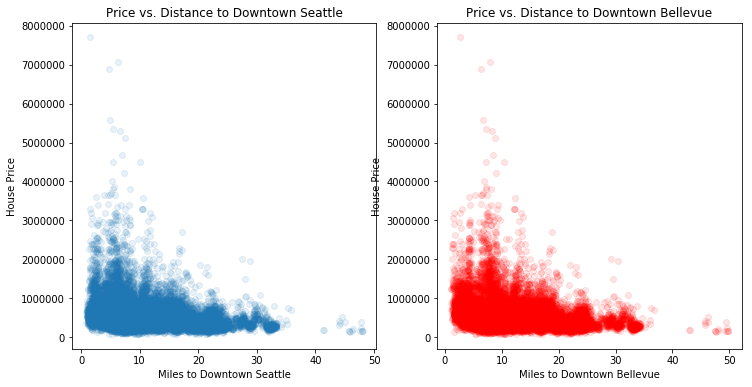

In [709]:
fig, ax = plt.subplots(1,2,figsize=(12,6))

ax[0].scatter(df_distance['miles_to_dt_sea'],df['price'],alpha=0.1)
ax[0].set_title("Price vs. Distance to Downtown Seattle")
ax[0].set_xlabel("Miles to Downtown Seattle")
ax[0].set_ylabel("House Price")

ax[1].scatter(df_distance['miles_to_dt_belle'],df['price'],alpha=0.1, color='red')
ax[1].set_title("Price vs. Distance to Downtown Bellevue")
ax[1].set_xlabel("Miles to Downtown Bellevue")
ax[1].set_ylabel("House Price")

plt.show()

In [710]:
df_distance['miles_to_dt_sea'].head()

0     7.744606
1     7.723802
2    10.064832
3     6.698936
4    13.562820
Name: miles_to_dt_sea, dtype: float64

In [711]:
df_distance.head()

,miles_to_dt_sea,miles_to_dt_belle
0,7.744606,8.770690
1,7.723802,7.993244
2,10.064832,10.911701
3,6.698936,6.313183
4,13.562820,15.279537


Let's check to see what these `miles..` variables look like relative to `price`:

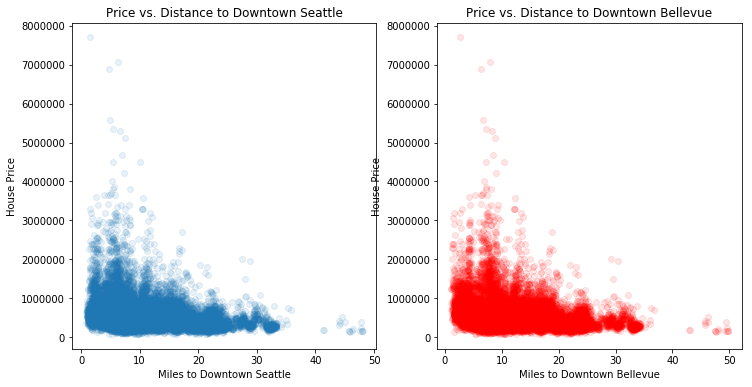

In [712]:
fig, ax = plt.subplots(1,2,figsize=(12,6))

ax[0].scatter(df_distance['miles_to_dt_sea'],df['price'],alpha=0.1)
ax[0].set_title("Price vs. Distance to Downtown Seattle")
ax[0].set_xlabel("Miles to Downtown Seattle")
ax[0].set_ylabel("House Price")

ax[1].scatter(df_distance['miles_to_dt_belle'],df['price'],alpha=0.1, color='red')
ax[1].set_title("Price vs. Distance to Downtown Bellevue")
ax[1].set_xlabel("Miles to Downtown Bellevue")
ax[1].set_ylabel("House Price")

plt.show()

## Model 6

We are performing training two un-trained columns(Distance from Seattle Downtown, Distance from Bellevue Downtown) with the existing model.

In [713]:
# Set up predictors
predictors = sm.add_constant(df_x_train_dummy)

# Model SM LR model
model_6 = sm.OLS(np.log(y_train), predictors).fit()

# View Results
model_6.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.889
Model:                            OLS   Adj. R-squared:                  0.888
Method:                 Least Squares   F-statistic:                     1335.
Date:                Wed, 17 Apr 2019   Prob (F-statistic):               0.00
Time:                        23:13:18   Log-Likelihood:                 5517.5
No. Observations:               17277   AIC:                        -1.083e+04
Df Residuals:                   17173   BIC:                        -1.002e+04
Df Model:                         103                                         
Covariance Type:            nonrobust                                         
=====================================================================================
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
const                82.7474     13.687      6.046      0.000      55.919     109.576
bedrooms             -0.0165      0.005     -3.167      0.002      -0.027      -0.006
bathrooms            -0.0051      0.009     -0.568      0.570      -0.023       0.013
sqft_lot           1.788e-07   6.16e-08      2.901      0.004     5.8e-08       3e-07
grade                 0.0861      0.002     37.731      0.000       0.082       0.091
sqft_above            0.0001   8.21e-06     12.242      0.000    8.45e-05       0.000
sqft_basement         0.0001   4.38e-06     28.544      0.000       0.000       0.000
yr_built              0.0001   8.87e-05      1.233      0.217   -6.44e-05       0.000
yr_renovated       3.921e-05   3.99e-06      9.825      0.000    3.14e-05     4.7e-05
lat                   0.0262      0.084      0.312      0.755      -0.139       0.191
long                  0.6068      0.099      6.135      0.000       0.413       0.801
sqft_living15     -1.732e-05   1.13e-05     -1.533      0.125   -3.95e-05    4.83e-06
sqft_lot15        -1.925e-07   9.69e-08     -1.987      0.047   -3.82e-07   -2.59e-09
98001                -0.4898      0.037    -13.262      0.000      -0.562      -0.417
98002                -0.5170      0.038    -13.588      0.000      -0.592      -0.442
98003                -0.4653      0.037    -12.548      0.000      -0.538      -0.393
98004                 0.1296      0.030      4.258      0.000       0.070       0.189
98005                -0.2339      0.033     -7.176      0.000      -0.298      -0.170
98006                -0.2904      0.030     -9.616      0.000      -0.350      -0.231
98007                -0.2966      0.033     -8.927      0.000      -0.362      -0.231
98008                -0.2655      0.031     -8.467      0.000      -0.327      -0.204
98010                -0.3185      0.042     -7.500      0.000      -0.402      -0.235
98011                -0.3781      0.029    -13.259      0.000      -0.434      -0.322
98014                -0.4379      0.039    -11.093      0.000      -0.515      -0.361
98019                -0.4426      0.036    -12.262      0.000      -0.513      -0.372
98022                -0.3170      0.047     -6.748      0.000      -0.409      -0.225
98023                -0.4625      0.038    -12.221      0.000      -0.537      -0.388
98024                -0.3522      0.041     -8.661      0.000      -0.432      -0.273
98027                -0.3275      0.032    -10.198      0.000      -0.390      -0.265
98028                -0.4057      0.026    -15.627      0.000      -0.457      -0.355
98029                -0.2302      0.033     -6.923      0.000      -0.295      -0.165
98030                -0.5909      0.034    -17.557      0.000      -0.657      -0.525
98031                -0.6294      0.032    -19.844      0.000      -0.692

Hurry!! It's resulting $R^2$= 0.889 is the best result model so far. And its relationship to Model 3 is similar to that of Model 4, i.e. slightly favorable.

## Cross Validation - Untrained columns

In [714]:
linreg = LinearRegression()
X = df_x_train_dummy
y = np.log(y_train)

In [715]:
cv_10_res_mean = np.mean(cross_val_score(linreg, X, y, cv=10, scoring="neg_mean_squared_error"))
cv_10_res_std = np.std(cross_val_score(linreg, X, y, cv=10, scoring="neg_mean_squared_error"))

In [716]:
print("Accuracy: {:,.2f} (+/- {:,.2f})".format(cv_10_res_mean, cv_10_res_std * 2))

Accuracy: -0.03 (+/- 0.00)


**2019.04.18 - above CV replaced with below**

In [930]:
res_mod = dad.custom_k_fold(df_x_train_dummy, np.log(y_train), 10, verbose=False, log=True)

In [931]:
res_df = pd.DataFrame(res_mod)

In [932]:
results.append(store_results_to_dict('model_6','Model 6 with the log transformed price, including all the variables and distance'
                                     ,model_6.df_model
                                     ,model_6.rsquared, model_6.rsquared_adj
                                     ,np.mean(res_df['mse_test'])
                                     ,np.std(res_df['mse_test'])
                                     ,np.mean(res_df['rmse_test'])
                                     ,np.std(res_df['rmse_test'])
                                     ,np.mean(res_df['mape_test'])
                                     ,np.std(res_df['mape_test'])
                                ))               

In [933]:
results

[{'model_name': 'model_1',
  'model_desc': 'All preliminary variables included',
  'num_predictors': 101.0,
  'r2': 0.8290043904363273,
  'r2_adj': 0.8279988267352543,
  'cv_10_mse_mean': 23806940212.021126,
  'cv_10_mse_std': 4226214140.899766,
  'cv_10_rmse_mean': 153743.6824331373,
  'cv_10_rmse_std': 13031.51272568752,
  'cv_10_mape_mean': 18.045001967784597,
  'cv_10_mape_std': 0.32677193317554243},
 {'model_name': 'model_2',
  'model_desc': 'Model 1 with >.05 p-value variables removed',
  'num_predictors': 85.0,
  'r2': 0.8275517957086925,
  'r2_adj': 0.8266991345857351,
  'cv_10_mse_mean': 23907363039.99174,
  'cv_10_mse_std': 4376806409.411534,
  'cv_10_rmse_mean': 154035.6728649182,
  'cv_10_rmse_std': 13430.358336382871,
  'cv_10_mape_mean': 18.133235450268806,
  'cv_10_mape_std': 0.33239871212372457},
 {'model_name': 'model_3',
  'model_desc': 'Model 2 with log-transformed Price',
  'num_predictors': 85.0,
  'r2': 0.8847257942920856,
  'r2_adj': 0.8841558270135578,
  'cv_10_

---

## Model 7

Model 6 with removing features variables (p-values > 0.05)

In [719]:
# So one brute-force way to pare down this model is throw out variables that have high p-values.
drop_candidates = model_6.pvalues[model_6.pvalues > .05].reset_index()['index'].tolist()
drop_candidates

['bathrooms',
 'yr_built',
 'lat',
 'sqft_living15',
 '98102',
 '98105',
 '98112',
 '98117',
 '98199',
 'bedrooms_log',
 'floors_1.0',
 'floors_2.0',
 'floors_2.5',
 'floors_3.0',
 'miles_to_dt_belle']

In [720]:
X_train_dist_log = df_x_train_dummy.copy()

In [721]:
X_train_dist_log.drop(drop_candidates,axis=1,inplace=True)

In [722]:
X_train_dist_log.columns

Index(['bedrooms', 'sqft_lot', 'grade', 'sqft_above', 'sqft_basement',
       'yr_renovated', 'long', 'sqft_lot15', '98001', '98002', '98003',
       '98004', '98005', '98006', '98007', '98008', '98010', '98011', '98014',
       '98019', '98022', '98023', '98024', '98027', '98028', '98029', '98030',
       '98031', '98032', '98033', '98034', '98038', '98039', '98040', '98042',
       '98045', '98052', '98053', '98055', '98056', '98058', '98059', '98065',
       '98070', '98072', '98074', '98075', '98077', '98092', '98103', '98106',
       '98108', '98109', '98115', '98116', '98118', '98119', '98122', '98125',
       '98126', '98133', '98136', '98144', '98146', '98148', '98155', '98166',
       '98168', '98177', '98178', '98188', '98198', 'sqft_above_log',
       'sqft_living15_log', 'sqft_lot15_log', 'bathrooms_log', 'sqft_lot_log',
       'floors_1.5', 'wf_0.0', 'view_0.0', 'view_1.0', 'view_2.0', 'view_3.0',
       'cond_1', 'cond_2', 'cond_3', 'cond_4', 'miles_to_dt_sea'],
      dty

In [723]:
# Set up predictors
predictors = sm.add_constant(X_train_dist_log)

# Model SM LR model
model_7 = sm.OLS(y_train, predictors).fit()

# View Results
model_7.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.821
Model:                            OLS   Adj. R-squared:                  0.820
Method:                 Least Squares   F-statistic:                     893.5
Date:                Wed, 17 Apr 2019   Prob (F-statistic):               0.00
Time:                        23:13:20   Log-Likelihood:            -2.3108e+05
No. Observations:               17277   AIC:                         4.623e+05
Df Residuals:                   17188   BIC:                         4.630e+05
Df Model:                          88                                         
Covariance Type:            nonrobust                                         
=====================================================================================
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
const              1.146e+08   6.42e+06     17.839      0.000    1.02e+08    1.27e+08
bedrooms          -1.179e+04   1706.737     -6.910      0.000   -1.51e+04   -8447.896
sqft_lot             -0.1502      0.054     -2.783      0.005      -0.256      -0.044
grade              6.093e+04   1918.056     31.766      0.000    5.72e+04    6.47e+04
sqft_above          352.9005      5.723     61.663      0.000     341.683     364.118
sqft_basement       137.4759      3.656     37.599      0.000     130.309     144.643
yr_renovated         27.7996      3.372      8.243      0.000      21.189      34.410
long                9.13e+05   5.25e+04     17.403      0.000     8.1e+05    1.02e+06
sqft_lot15           -0.4498      0.085     -5.289      0.000      -0.616      -0.283
98001             -8.638e+04   1.84e+04     -4.693      0.000   -1.22e+05   -5.03e+04
98002             -9.082e+04      2e+04     -4.533      0.000    -1.3e+05   -5.15e+04
98003             -6.765e+04   1.91e+04     -3.544      0.000   -1.05e+05   -3.02e+04
98004              2.487e+05    1.3e+04     19.197      0.000    2.23e+05    2.74e+05
98005             -1.999e+05    1.7e+04    -11.780      0.000   -2.33e+05   -1.67e+05
98006             -2.318e+05   1.31e+04    -17.646      0.000   -2.57e+05   -2.06e+05
98007             -2.535e+05   1.82e+04    -13.963      0.000   -2.89e+05   -2.18e+05
98008             -2.386e+05   1.58e+04    -15.133      0.000   -2.69e+05   -2.08e+05
98010              -1.81e+05   2.68e+04     -6.744      0.000   -2.34e+05   -1.28e+05
98011             -2.524e+05   1.51e+04    -16.678      0.000   -2.82e+05   -2.23e+05
98014             -3.277e+05    2.8e+04    -11.686      0.000   -3.83e+05   -2.73e+05
98019             -3.135e+05   2.32e+04    -13.525      0.000   -3.59e+05   -2.68e+05
98022             -5.872e+04   2.73e+04     -2.149      0.032   -1.12e+05   -5156.759
98023             -4.007e+04   1.94e+04     -2.065      0.039   -7.81e+04   -2030.528
98024             -2.846e+05    2.9e+04     -9.815      0.000   -3.41e+05   -2.28e+05
98027             -2.777e+05   1.71e+04    -16.209      0.000   -3.11e+05   -2.44e+05
98028              -2.39e+05   1.29e+04    -18.496      0.000   -2.64e+05   -2.14e+05
98029              -2.32e+05   1.93e+04    -12.041      0.000    -2.7e+05   -1.94e+05
98030             -2.203e+05   1.69e+04    -13.040      0.000   -2.53e+05   -1.87e+05
98031             -2.706e+05   1.55e+04    -17.470      0.000   -3.01e+05    -2.4e+05
98032             -1.887e+05   1.95e+04     -9.678      0.000   -2.27e+05    -1.5e+05
98033              -1.11e+05   1.21e+04     -9.146      0.000   -1.35e+05   -8.72e+04
98034             -2.225e+05   1.11e+04    -20.003      0.000   -2.44e+05   -2.01e+05
98038             -2.464e+05   1.92e+04    -12.839      0.000   -2.84e+05

So this model is also worse so far. And we also see that certain variables are now insignificant (Distance from Bellevue), whereas they were not before. Maybe this is indication of uncaught multicollinearity?

## Cross Validation - Round 7

In [724]:
linreg = LinearRegression()
X = X_train_dist_log
y = np.log(y_train)

In [725]:
cv_10_res_mean = np.mean(cross_val_score(linreg, X, y, cv=10, scoring="neg_mean_squared_error"))
cv_10_res_std = np.std(cross_val_score(linreg, X, y, cv=10, scoring="neg_mean_squared_error"))

In [726]:
print("Accuracy: {:,.2f} (+/- {:,.2f})".format(cv_10_res_mean, cv_10_res_std * 2))

Accuracy: -0.03 (+/- 0.00)


**2019.04.18 - above CV replaced with below**

In [934]:
res_mod = dad.custom_k_fold(X_train_dist_log, np.log(y_train), 10, verbose=False, log=True)

In [935]:
res_df = pd.DataFrame(res_mod)

In [936]:
results.append(store_results_to_dict('model_7','Model 6 with the p-value variables > .05 removed'
                                     ,model_7.df_model
                                     ,model_7.rsquared, model_7.rsquared_adj
                                     ,np.mean(res_df['mse_test'])
                                     ,np.std(res_df['mse_test'])
                                     ,np.mean(res_df['rmse_test'])
                                     ,np.std(res_df['rmse_test'])
                                     ,np.mean(res_df['mape_test'])
                                     ,np.std(res_df['mape_test'])
                                ))               

In [937]:
results

[{'model_name': 'model_1',
  'model_desc': 'All preliminary variables included',
  'num_predictors': 101.0,
  'r2': 0.8290043904363273,
  'r2_adj': 0.8279988267352543,
  'cv_10_mse_mean': 23806940212.021126,
  'cv_10_mse_std': 4226214140.899766,
  'cv_10_rmse_mean': 153743.6824331373,
  'cv_10_rmse_std': 13031.51272568752,
  'cv_10_mape_mean': 18.045001967784597,
  'cv_10_mape_std': 0.32677193317554243},
 {'model_name': 'model_2',
  'model_desc': 'Model 1 with >.05 p-value variables removed',
  'num_predictors': 85.0,
  'r2': 0.8275517957086925,
  'r2_adj': 0.8266991345857351,
  'cv_10_mse_mean': 23907363039.99174,
  'cv_10_mse_std': 4376806409.411534,
  'cv_10_rmse_mean': 154035.6728649182,
  'cv_10_rmse_std': 13430.358336382871,
  'cv_10_mape_mean': 18.133235450268806,
  'cv_10_mape_std': 0.33239871212372457},
 {'model_name': 'model_3',
  'model_desc': 'Model 2 with log-transformed Price',
  'num_predictors': 85.0,
  'r2': 0.8847257942920856,
  'r2_adj': 0.8841558270135578,
  'cv_10_

---

# Model 8 - Log transformed `Price` + Stepwise Selection

Here we will build on Model 3 by running it through a stepwise selection algorithm to see if it can determine a more 'optimized' subset of variables.


We will need a Stepwise Selection algorithm; we will just use the one from the textbook!

In [729]:
#import statsmodels.api as sm

def stepwise_selection(X, y, 
                       initial_list=[], 
                       threshold_in=0.01, 
                       threshold_out = 0.05, 
                       verbose=True):
    """ Perform a forward-backward feature selection 
    based on p-value from statsmodels.api.OLS
    Arguments:
        X - pandas.DataFrame with candidate features
        y - list-like with the target
        initial_list - list of features to start with (column names of X)
        threshold_in - include a feature if its p-value < threshold_in
        threshold_out - exclude a feature if its p-value > threshold_out
        verbose - whether to print the sequence of inclusions and exclusions
    Returns: list of selected features 
    Always set threshold_in < threshold_out to avoid infinite looping.
    See https://en.wikipedia.org/wiki/Stepwise_regression for the details
    """
    included = list(initial_list)
    while True:
        changed=False
        # forward step
        excluded = list(set(X.columns)-set(included))
        new_pval = pd.Series(index=excluded)
        for new_column in excluded:
            model = sm.OLS(y, sm.add_constant(pd.DataFrame(X[included+[new_column]]))).fit()
            new_pval[new_column] = model.pvalues[new_column]
        best_pval = new_pval.min()
        if best_pval < threshold_in:
            best_feature = new_pval.idxmin()
            included.append(best_feature)
            changed=True
            if verbose:
                print('Add  {:30} with p-value {:.6}'.format(best_feature, best_pval))

        # backward step
        model = sm.OLS(y, sm.add_constant(pd.DataFrame(X[included]))).fit()
        # use all coefs except intercept
        pvalues = model.pvalues.iloc[1:]
        worst_pval = pvalues.max() # null if pvalues is empty
        if worst_pval > threshold_out:
            changed=True
            worst_feature = pvalues.argmax()
            included.remove(worst_feature)
            if verbose:
                print('Drop {:30} with p-value {:.6}'.format(worst_feature, worst_pval))
        if not changed:
            break
    return included

Let's see what the selected variables are!

In [730]:
#sw_selected = stepwise_selection(df_x_train_dummy, np.log(y_train), verbose = True)

Add  bedrooms_log                   with p-value 0.0
Add  sqft_above                     with p-value 0.0
Add  sqft_living15                  with p-value 0.0
Add  miles_to_dt_belle              with p-value 0.0
Add  lat                            with p-value 0.0
Add  grade                          with p-value 0.0
Add  sqft_basement                  with p-value 0.0
Add  long                           with p-value 1.16932e-217
Add  yr_built                       with p-value 1.47088e-182
Add  wf_0.0                         with p-value 2.32207e-158
Drop bedrooms_log                   with p-value 0.80206


/anaconda3/envs/learn-env/lib/python3.6/site-packages/ipykernel_launcher.py:45: FutureWarning: 'argmax' is deprecated, use 'idxmax' instead. The behavior of 'argmax'
will be corrected to return the positional maximum in the future.
Use 'series.values.argmax' to get the position of the maximum now.


Add  98004                          with p-value 1.18689e-153
Add  98168                          with p-value 1.10304e-116
Add  view_0.0                       with p-value 3.25481e-107
Add  98178                          with p-value 3.13131e-114
Add  sqft_above_log                 with p-value 1.11221e-103
Add  98022                          with p-value 1.80159e-92
Add  98106                          with p-value 5.37802e-61
Add  98055                          with p-value 3.61246e-64
Add  98118                          with p-value 7.36789e-69
Add  98108                          with p-value 1.90534e-69
Add  98058                          with p-value 8.50848e-73
Add  98056                          with p-value 7.96667e-73
Add  98146                          with p-value 2.27063e-71
Add  sqft_lot                       with p-value 6.1478e-71
Add  98188                          with p-value 2.07689e-55
Add  98059                          with p-value 4.8409e-58
Add  98144           

In [731]:
len(sw_selected)

76

#### Update  2019.04.19
So, the random seeds we ran with don't appears to be consistent across our various runs; what this means specifically is what we believe is our seed (1111) doesn't seem to reproduce the results we were already committed to recommending. Re-testing on 1111 produces 'in-the-ballpark' results (e.g. 82 selected variables), but not an exact repoduction.

In the interest of documentation, we will manually record the 76 'officially' recommended variables so that they don't get lost upon any future re-runs of this code:

In [ ]:
# Time Machine
sw_selected = ['sqft_above','miles_to_dt_belle','grade','sqft_basement','long','wf_0.0','98004','98168','view_0.0',
               '98178','sqft_above_log','98022','98106','98055','98118','98108','98058','98056','98146','sqft_lot',
               '98188','98059','98144','98031','98039','98126','98042','cond_3','98198','98030','98032',
               'bathrooms_log','98117','98112','sqft_lot_log','98166','cond_2','98133','98155','98028','98045',
               '98034','98148','98125','cond_4','cond_1','98122','yr_renovated','sqft_living15_log','98065','98029',
               '98010','floors_3.0','view_2.0','98011','98105','view_1.0','view_3.0','98040','lat','98072','98019',
               '98077','98177','98119','98109','98014','98052','98074','98102','floors_1.5','bedrooms',
               'sqft_lot15_log','98007','98053','floors_2.0']

--- **End Update**

In [732]:
df_x_train_dummy.shape

(17277, 103)

In [733]:
X_train_dist_stepwise_log = df_x_train_dummy.loc[:,sw_selected]

In [734]:
X_train_dist_stepwise_log.columns
X_train_dist_stepwise_log.shape

(17277, 76)

In [735]:
# Set up predictors
predictors = sm.add_constant(X_train_dist_stepwise_log)

# Model SM LR model
model_8 = sm.OLS(np.log(y_train), predictors).fit()

# View Results
model_8.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.887
Model:                            OLS   Adj. R-squared:                  0.887
Method:                 Least Squares   F-statistic:                     1781.
Date:                Wed, 17 Apr 2019   Prob (F-statistic):               0.00
Time:                        23:18:52   Log-Likelihood:                 5385.5
No. Observations:               17277   AIC:                        -1.062e+04
Df Residuals:                   17200   BIC:                        -1.002e+04
Df Model:                          76                                         
Covariance Type:            nonrobust                                         
=====================================================================================
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
const                36.9113      5.232      7.055      0.000      26.656      47.167
sqft_above         9.143e-05   6.48e-06     14.102      0.000    7.87e-05       0.000
miles_to_dt_belle    -0.0342      0.001    -35.525      0.000      -0.036      -0.032
grade                 0.0860      0.002     39.597      0.000       0.082       0.090
sqft_basement         0.0001    4.3e-06     29.159      0.000       0.000       0.000
long                  0.5551      0.030     18.745      0.000       0.497       0.613
wf_0.0               -0.4633      0.020    -22.846      0.000      -0.503      -0.424
98004                 0.3397      0.012     28.714      0.000       0.317       0.363
98168                -0.4959      0.013    -37.059      0.000      -0.522      -0.470
view_0.0             -0.2730      0.014    -19.833      0.000      -0.300      -0.246
98178                -0.4327      0.013    -33.326      0.000      -0.458      -0.407
sqft_above_log        0.2232      0.014     16.381      0.000       0.196       0.250
98022                 0.3281      0.015     22.048      0.000       0.299       0.357
98106                -0.3381      0.012    -28.291      0.000      -0.361      -0.315
98055                -0.3183      0.013    -24.938      0.000      -0.343      -0.293
98118                -0.2371      0.010    -22.784      0.000      -0.257      -0.217
98108                -0.3581      0.015    -23.288      0.000      -0.388      -0.328
98058                -0.2502      0.010    -24.717      0.000      -0.270      -0.230
98056                -0.2611      0.011    -24.598      0.000      -0.282      -0.240
98146                -0.3119      0.013    -24.757      0.000      -0.337      -0.287
sqft_lot           1.582e-07   4.97e-08      3.181      0.001    6.07e-08    2.56e-07
98188                -0.3459      0.017    -20.065      0.000      -0.380      -0.312
98059                -0.1830      0.010    -18.435      0.000      -0.203      -0.164
98144                -0.1372      0.012    -11.509      0.000      -0.161      -0.114
98031                -0.2318      0.013    -18.493      0.000      -0.256      -0.207
98039                 0.4510      0.029     15.741      0.000       0.395       0.507
98126                -0.1429      0.012    -12.226      0.000      -0.166      -0.120
98042                -0.1244      0.009    -13.124      0.000      -0.143      -0.106
cond_3               -0.1080      0.005    -20.064      0.000      -0.119      -0.097
98198                -0.1972      0.013    -15.609      0.000      -0.222      -0.172
98030                -0.1589      0.013    -12.235      0.000      -0.184      -0.133
98032                -0.2435      0.018    -13.529      0.000      -0.279      -0.208
bathrooms_log         0.0765      0.006     12.671      0.000       0.065

It's resulting $R^2$= 0.887 is the best result model so far. And its relationship to Model 3 is similar to that of Model 4 and Model 6, i.e. slightly favorable.

## Cross Validation - Round 8

In [955]:
linreg = LinearRegression()
X = X_train_dist_stepwise_log
y = np.log(y_train)

In [737]:
cv_10_res_mean = np.mean(cross_val_score(linreg, X, y, cv=10, scoring="neg_mean_squared_error"))
cv_10_res_std = np.std(cross_val_score(linreg, X, y, cv=10, scoring="neg_mean_squared_error"))

In [738]:
print("Accuracy: {:,.2f} (+/- {:,.2f})".format(cv_10_res_mean, cv_10_res_std * 2))

Accuracy: -0.03 (+/- 0.00)


**2019.04.18 - above CV replaced with below**

In [938]:
res_mod = dad.custom_k_fold(X_train_dist_stepwise_log, np.log(y_train), 10, verbose=False, log=True)

In [939]:
res_df = pd.DataFrame(res_mod)

In [940]:
results.append(store_results_to_dict('model_8','Model 6 with step-wise selected variables'
                                     ,model_8.df_model
                                     ,model_8.rsquared, model_8.rsquared_adj
                                     ,np.mean(res_df['mse_test'])
                                     ,np.std(res_df['mse_test'])
                                     ,np.mean(res_df['rmse_test'])
                                     ,np.std(res_df['rmse_test'])
                                     ,np.mean(res_df['mape_test'])
                                     ,np.std(res_df['mape_test'])
                                ))               

In [941]:
results

[{'model_name': 'model_1',
  'model_desc': 'All preliminary variables included',
  'num_predictors': 101.0,
  'r2': 0.8290043904363273,
  'r2_adj': 0.8279988267352543,
  'cv_10_mse_mean': 23806940212.021126,
  'cv_10_mse_std': 4226214140.899766,
  'cv_10_rmse_mean': 153743.6824331373,
  'cv_10_rmse_std': 13031.51272568752,
  'cv_10_mape_mean': 18.045001967784597,
  'cv_10_mape_std': 0.32677193317554243},
 {'model_name': 'model_2',
  'model_desc': 'Model 1 with >.05 p-value variables removed',
  'num_predictors': 85.0,
  'r2': 0.8275517957086925,
  'r2_adj': 0.8266991345857351,
  'cv_10_mse_mean': 23907363039.99174,
  'cv_10_mse_std': 4376806409.411534,
  'cv_10_rmse_mean': 154035.6728649182,
  'cv_10_rmse_std': 13430.358336382871,
  'cv_10_mape_mean': 18.133235450268806,
  'cv_10_mape_std': 0.33239871212372457},
 {'model_name': 'model_3',
  'model_desc': 'Model 2 with log-transformed Price',
  'num_predictors': 85.0,
  'r2': 0.8847257942920856,
  'r2_adj': 0.8841558270135578,
  'cv_10_

---

## Results to Date

In [942]:
df_model_results = pd.DataFrame(results)
df_model_results.head(20)

,cv_10_mape_mean,cv_10_mape_std,cv_10_mse_mean,cv_10_mse_std,cv_10_rmse_mean,cv_10_rmse_std,model_desc,model_name,num_predictors,r2,r2_adj
0,18.045002,0.326772,2.380694e+10,4.226214e+09,153743.682433,13031.512726,All preliminary variables included,model_1,101.0,0.829004,0.827999
1,18.133235,0.332399,2.390736e+10,4.376806e+09,154035.672865,13430.358336,Model 1 with >.05 p-value variables removed,model_2,85.0,0.827552,0.826699
2,13.532890,0.308308,1.740683e+10,4.616785e+09,130927.187819,16275.785005,Model 2 with log-transformed Price,model_3,85.0,0.884726,0.884156
3,13.446040,0.299989,1.709464e+10,4.100164e+09,129904.001338,14818.551861,"All preliminary variables included, log-transf...",model_4,101.0,0.886168,0.885498
4,13.500939,0.314050,1.742136e+10,4.811397e+09,130893.187795,16980.292557,Model 4 with >.05 p-value variables removed,model_5,87.0,0.821313,0.820409
5,13.241489,0.326116,1.662895e+10,3.872933e+09,128163.339339,14251.439330,"Model 6 with the log transformed price, includ...",model_6,103.0,0.888971,0.888305
6,13.316277,0.334384,1.718537e+10,4.729584e+09,130004.660559,16856.976299,Model 6 with the p-value variables > .05 removed,model_7,88.0,0.820614,0.819696
7,13.359580,0.315477,1.665179e+10,3.794830e+09,128280.440862,13996.986755,Model 6 with step-wise selected variables,model_8,76.0,0.887263,0.886764


Our preliminary recommendation is to go with __**Model 8**__. While by raw metrics model 6 appears to outperform slightly, we believe that a (relatively) simpler model (i.e. fewer required predictors) that performs equally as well, is a superior overall choice. **In other words, less data is needed to get a similar answer.**

To summarize its characteristics:  
- All our original cleaned and binarized variables (see Model 1).
- Target variable `price` is log-transformed to make it more `Normal`.
- We engineered two features for distance to downtowns in Seattle and Bellevue and added to our pool of features.
- We ran through stepwise selection with inclusion threshold of <.01 and exclusion threshold of >.05.

**This left us with 76 features.**

**$R^2_{adj}$ of .887.**

**MAPE = 13.4, in other words the average percent error of a predicted house price is off by about 13.4%. Oh well.**

---

# Further Assessment on the Recommended Model

## Normality Check

/anaconda3/envs/learn-env/lib/python3.6/site-packages/matplotlib/figure.py:445: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  % get_backend())


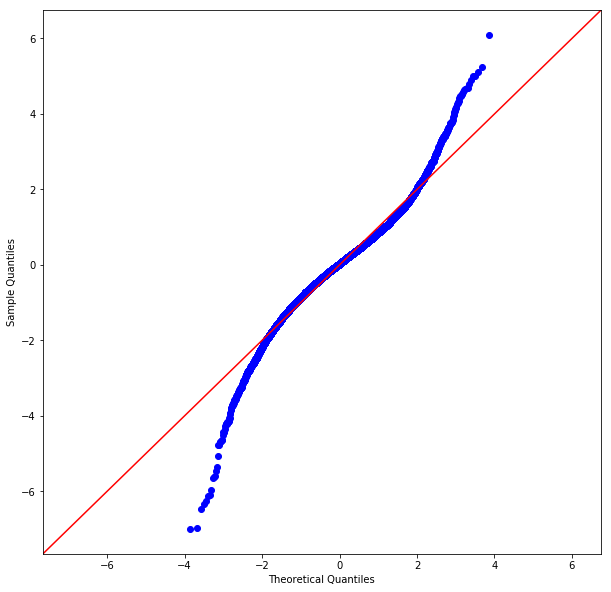

In [1041]:
resid1 = model_8.resid

fig,ax = plt.subplots(figsize=(10,10))
fig = sm.graphics.qqplot(resid1, dist=stats.norm, line='45', fit=True, ax=ax)
fig.show()

Here `QQ-Plot` is looking good in the middle but the values at tail are inconsistent.

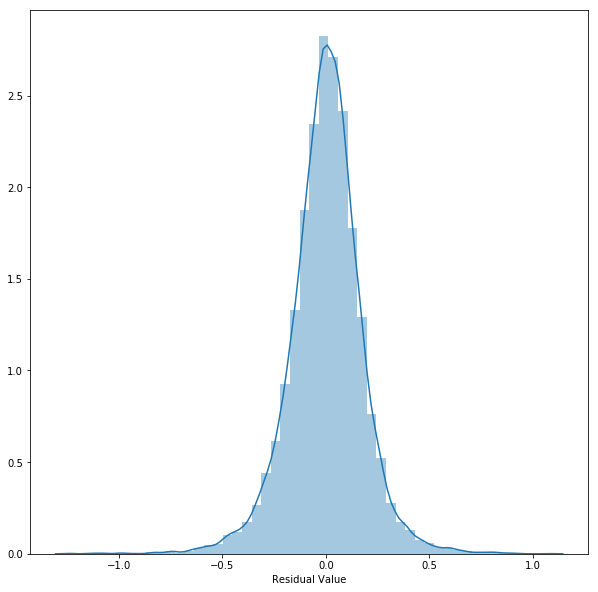

In [1042]:
fig,ax = plt.subplots(figsize=(10,10))

ax = sns.distplot(resid1, axlabel='Residual Value',ax=ax)
ax.set_title = 'Distribution Plot of Residuals'
ax.set_ylabel = 'Counts'



From the 'eye-test' the residual seem pretty normal, but the qq-plot further reveals failure at the tails, so in actuality our residuals are not strictly Gaussian. For now due to time constraints we feel it is 'normal enough' to proceed with our recommended model.

# Run vs Test 

Now we want to run out Test data vs our selected model. 

First we need to create an ingestible version of our data.

In [939]:
res_df1 = pd.DataFrame(res_mod)

In [945]:
X_test.shape

(4320, 102)

In [939]:
res_df1 = pd.DataFrame(res_mod)

In [946]:
df_x_test = pd.concat([X_test, df_distance], axis=1, join = 'inner')
df_x_test.head()

,bedrooms,bathrooms,sqft_lot,grade,sqft_above,sqft_basement,yr_built,yr_renovated,lat,long,...,view_0.0,view_1.0,view_2.0,view_3.0,cond_1,cond_2,cond_3,cond_4,miles_to_dt_sea,miles_to_dt_belle
16277,3,1.75,15232,8,1570,1200,1976,0.0,47.5706,-122.160,...,1,0,0,0,0,0,1,0,8.637006,10.310781
13460,2,1.00,3700,6,800,200,1929,0.0,47.5520,-122.290,...,1,0,0,0,0,0,1,0,4.532683,5.626049
8006,2,1.00,4000,7,930,500,1949,0.0,47.5233,-122.284,...,1,0,0,0,0,0,1,0,6.449524,7.351616
4535,3,3.50,108900,9,2700,680,1999,0.0,47.4316,-122.075,...,1,0,0,0,0,0,1,0,17.317864,18.632898
7661,6,4.50,6420,8,2360,1870,1916,0.0,47.6301,-122.369,...,0,0,0,1,0,0,0,1,2.080691,1.321183


In [948]:
df_x_test.shape

(4320, 104)

In [949]:
df_x_test.columns

Index(['bedrooms', 'bathrooms', 'sqft_lot', 'grade', 'sqft_above',
       'sqft_basement', 'yr_built', 'yr_renovated', 'lat', 'long',
       ...
       'view_0.0', 'view_1.0', 'view_2.0', 'view_3.0', 'cond_1', 'cond_2',
       'cond_3', 'cond_4', 'miles_to_dt_sea', 'miles_to_dt_belle'],
      dtype='object', length=104)

In [950]:
df_x_test['date_formatted'].head()

16277   2015-03-30
13460   2015-03-10
8006    2014-07-23
4535    2014-06-16
7661    2014-07-09
Name: date_formatted, dtype: datetime64[ns]

In [951]:
# Don't forget to drop date_formatted again!
df_x_test.drop(['date_formatted'],axis=1,inplace=True)

In [952]:
df_x_test.shape

(4320, 103)

In [953]:
df_x_test_sw = df_x_test.loc[:,sw_selected]

In [954]:
df_x_test_sw.shape

(4320, 76)

Good, we matched, at least on number of columns.

Let's get predictions for our test!

In [997]:
# Set up predictors
test_predictions = model_8.predict(sm.add_constant(df_x_test_sw))

## Compare Actual vs Predict (Test Data)

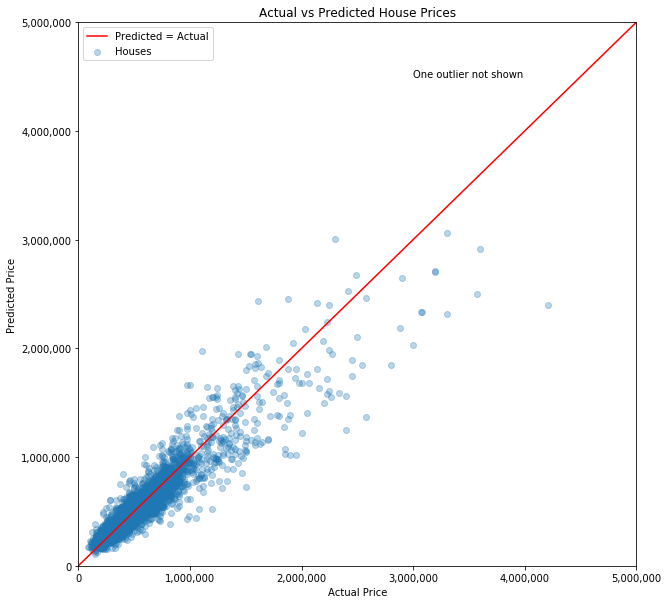

In [1043]:
import matplotlib

fig, ax = plt.subplots(figsize=(10,10))

x = np.linspace(0, 5000000)

ax.get_xaxis().set_major_formatter(
    matplotlib.ticker.FuncFormatter(lambda x, p: format(int(x), ',')))
ax.get_yaxis().set_major_formatter(
    matplotlib.ticker.FuncFormatter(lambda y, p: format(int(y), ',')))

ax.set_title("Actual vs Predicted House Prices")
ax.plot(x, x, color = "red", label = 'Predicted = Actual')
ax.scatter(y_test,np.exp(test_predictions),alpha = .3, label = 'Houses' )
ax.set_xlim(0,5000000)
ax.set_ylim(0,5000000)
ax.set_xlabel("Actual Price")
ax.set_ylabel("Predicted Price")
ax.legend()
plt.text(3000000,4500000,'One outlier not shown')
plt.show()

## Top 10 Predictors: p-values

...at least from a p-value perspective.

In [1008]:
model_8.pvalues.sort_values().head(10)

grade                 0.000000e+00
98168                2.713777e-289
miles_to_dt_belle    8.222971e-267
98178                4.861285e-236
sqft_basement        1.737299e-182
98004                3.793378e-177
98106                3.776679e-172
98055                7.127708e-135
98146                5.530581e-133
98058                1.427867e-132
dtype: float64

## Top 10 Coefficients by absolute value

**But keep in mind we didn't standardize all our variables!** So take with a grain of salt.

In [1013]:
model_8.params.apply(np.abs).sort_values().tail(10)

98188      0.345875
98108      0.358147
cond_1     0.432067
98178      0.432729
98039      0.450959
wf_0.0     0.463306
98168      0.495927
long       0.555098
lat        0.865453
const     36.911270
dtype: float64

## Metrics

Recall the metrics for our train set:

In [1135]:
# note these are averages of the metrics over the folds
train_mse = df_model_results['cv_10_mse_mean'].loc[df_model_results['model_name']=='model_8']
#print(train_mse.iloc[0])


16651787146.029919


In [1142]:
print("Train MSE: " + str(round(train_mse.iloc[0],0)))

train_rmse = np.sqrt(train_mse)
print("Train RMSE: " + str(round(train_rmse.iloc[0],0)))

train_mape = df_model_results['cv_10_mape_mean'].loc[df_model_results['model_name']=='model_8'].iloc[0]
print("Train MAPE: " + str(round(train_mape,1)))

Train MSE: 16651787146.0
Train RMSE: 129042.0
Train MAPE: 13.4


In [1143]:
from sklearn.metrics import mean_squared_error

# train_mse = mean_squared_error(y_train, y_hat_train)
# test_mse = mean_squared_error(y_test, y_hat_test)
# print('Train Mean Squarred Error:', train_mse)
# print('Test Mean Squarred Error:', test_mse)

# MSE/RMSE
test_mse = mean_squared_error(y_test, np.exp(test_predictions))
print("Test MSE: " + str(round(test_mse,0)))
test_rmse = np.sqrt(test_mse)
print("Test RMSE: " + str(round(test_rmse,0)))

# MAPE
test_mape = dad.mape(np.exp(test_predictions), y_test)
print("Test MAPE: " + str(round(test_mape,1)))


Test MSE: 17016647184.0
Test RMSE: 130448.0
Test MAPE: 13.6


The results of the test set is close (from our subjective point of view) to the train. So we feel fairly confident in the generalizability of our model.

Let's plot our model all metrics so we can see the evolution over the iterations.

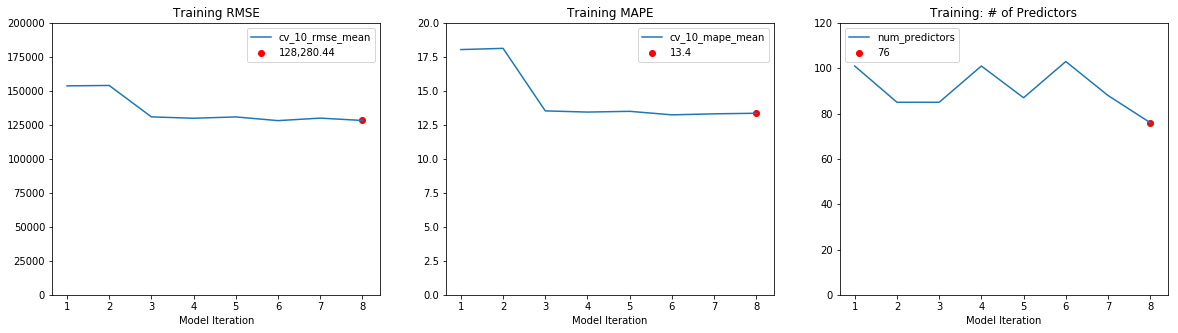

In [1099]:
fig, ax = plt.subplots(1,3, figsize=(20,5))

#ax[0,0].bar(df_model_results.index+1, df_model_results['cv_10_mape_mean'])
ax[0].plot(df_model_results.index+1, df_model_results['cv_10_rmse_mean'],label=None)
ax[0].set_title("Training RMSE")
ax[0].set_ylim(0,200000)
ax[0].scatter(8,df_model_results['cv_10_rmse_mean'][-1:],color='red',
              label=format(round(float(df_model_results['cv_10_rmse_mean'][-1:]),2),","))
ax[0].legend()
ax[0].set_xlabel('Model Iteration')

ax[1].plot(df_model_results.index+1, df_model_results['cv_10_mape_mean'])
ax[1].set_title("Training MAPE")
ax[1].set_ylim(0,20)
ax[1].scatter(8,df_model_results['cv_10_mape_mean'][-1:],color='red',
              label=round(float(df_model_results['cv_10_mape_mean'][-1:]),1))
ax[1].legend()
ax[1].set_xlabel('Model Iteration')

ax[2].plot(df_model_results.index+1, df_model_results['num_predictors'])
ax[2].set_title("Training: # of Predictors")
ax[2].set_ylim(0,120)
ax[2].scatter(8,df_model_results['num_predictors'][-1:],color='red',
              label=int(df_model_results['num_predictors'][-1:]))
ax[2].legend()
ax[2].set_xlabel('Model Iteration')

plt.show()

In [1103]:
round(float(df_model_results['cv_10_mape_mean'][-1:]),1)

13.4

What is 2 std around average MAPE?

In [1109]:
mape_bottom = round(float(df_model_results['cv_10_mape_mean'][-1:])-float(df_model_results['cv_10_mape_std'][-1:])*2,1)

In [1110]:
mape_top = round(float(df_model_results['cv_10_mape_mean'][-1:])+float(df_model_results['cv_10_mape_std'][-1:])*2,1)

In [1112]:
print("2 standard deviation range of MAPE on training CV for model_8 is: " + str(mape_bottom) + ' to ' + str(mape_top))

2 SD range of MAPE on training CV for model_8 is: 12.7 to 14.0


In [1123]:
df_model_results.loc[[0,1,5,7],['model_name','model_desc','cv_10_rmse_mean','cv_10_mape_mean','num_predictors']
                    ].to_csv('blog_results_tbl.csv')

In [1124]:
#reduction of variables from model 6 to model 8 as pct
76/103-1

-0.2621359223300971